Team Members:
- Cruoglio Antonella, 2025992 
- Iovino Giuliana, 2017512
- Mascolo Davide, 2001991
- Napoli Mario, 2015169

# Using the Transformer Networks

This notebook will guide you through the usage of a provided efficient implementation of Transformer Networks, to experiment with hyper-parameters and to perform ablation studies. This notebook will let you master accomplishing experiments with Transformer Networks and analyising the outcomes. Complete the code snippets where request and provide your observations. Feel free to refer the paper [Under the Hood of Transformer Networks for Trajectory Forecasting](https://arxiv.org/abs/2203.11878).

 

# Initial setup

Only if you run from Google Colab run those 2 cells to sync with Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TF4AML

/content/drive/MyDrive/TF4AML


Start with the import

In [ ]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy
import os
import time

from transformer import baselineUtils
from transformer import individual_TF
from transformer.batch import subsequent_mask
from transformer.noam_opt import NoamOpt

In [ ]:
# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Current device: cuda - Type: Tesla T4


# Training and Testing

## Data Loading (setup the dataset for train, validation and test)

The subdatasets are 5 (ETH, Hotel, Univ, Zara1 and Zara2) we will leave one of them out for testing and train on the other 4. 

I.e. choosing ```dataset_name = 'zara1'``` the training set is composed by ETH, Hotel, Univ and Zara2 and tested on Zara1.

Moreover you can train and validate on a portion of the dataset setting percentage of the data (default is 50).

------ 

Each sequence is composed by an observed part to train the Encoder and a part we are attempting to predict with the Decoder. 

Generally the standard setup plans to use the first 8 points for the observation and the following 12 for the prediction.

------ 

Each created sequence has the shape (20, 4), where: 
- $N_{obs}+N_{pred} = 8 + 12 = 20$;
- Positions + Speeds = ( $x_i,\ y_i,\ u_i,\ v_i$) = ( $x_i,\ y_i,\ x_{i+1}-x_{i},\ y_{i+1} - y_i$ )

You can easily switch input type from position to speed setting the corresponding variable.

Speeds $u_i, v_i$ are generally more robust input and allow to avoid problems with the reference system.

------ 

Note: that $(u_0, v_0) = (0,0)$ and if speed are used the observed sequence has temporal length of $N_{obs} - 1$.

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'regr'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading students001_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading uni_examples_train.txt
004 / 007 - loading crowds_zara02_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_hotel_train.txt
007 / 007 - loading students003_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading biwi_hotel_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'speed'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

We compute the mean and standard deviation of positions or speeds across the full training dataset and use those to normalize each entry in the sequence.
This normalization is beneficial prior to processing with neural networks.

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

Following we create a torch dataloader that create the batches for each epoch.

In [ ]:
batch_size = 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

## Model instantiation

We create an instance of our transformer with the chosen configuration. 

Then we allocate it to the GPU for forward and backward accelerated computation.

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

## Training and Validation Step

Here we create two classes that define the single iteration function for train and validation.

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

## Optimizer

Here we select the **optimizer** proposed in the original Transformer Networks paper of Vaswani et al.

It uses some initial warmup epochs, where the learning rate is increased. Then it slowly decreases according to a number of epoch and the chosen embedding size. The resulting formula is:

LR = $\frac{F}{\sqrt{D}} min( \frac{1}{\sqrt{epoch}},\ epoch \cdot W^{-\frac{3}{2}}) $

where F is a scaling factor, D is the model embedding size, W is the number of warmup epochs.

In [ ]:
# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Main 


Then we can train, validate and test our transformer epoch by epoch.

-------

The **losses** used are 2:

1.   $L_2$-loss distance between predicted $(\hat{\textbf{u}}, \hat{\textbf{v}})$ and GT $(\textbf{u}, \textbf{v})$ target speeds;
2.   $L_1$-loss for the target token mask. Note these should be all zero, so the loss is simply the mean.

-------

Moreover, the **metrics** used to validate the model goodness at Validation and Test time are the following:

1.   Mean Average Displacement (MAD): $L_2$-distance between *all* the $N_pred$ GT and predicted future ***positions***;
2.   Final Average Displacement (FAD): $L_2$-distance between the *last* GT and predicted future ***positions***;

-------

Note: If you restart the training for any reason, remember to instanciate again model and optimizer in order to reset them.

-------

In [ ]:
# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")

## Utils for plots
train_loss_list = []
val_loss_list   = []
test_loss_list  = []

mad_train_12 = []
mad_val_12   = []
mad_test_12  = []

fad_train_12 = []
fad_val_12   = []
fad_test_12  = []


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    train_loss_list.append(train_loss)
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
    mad_train_12.append(mad)
    fad_train_12.append(fad)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        val_loss_list.append(val_loss)
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        mad_val_12.append(mad)
        fad_val_12.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        obs = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])
            obs.append(batch['src'][:, :, 0:2])


        test_loss_list.append(test_loss)
        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        obs = np.concatenate(obs, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)
        mad_test_12.append(mad)
        fad_test_12.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 294.6834 - MAD:  0.4182 - FAD:  0.6594
Total Eval  Loss: 657.5146 - MAD:  1.3104 - FAD:  2.5553
Total Test  Loss: 793.8191 - MAD:  2.1280 - FAD:  3.7863 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 175.3012 - MAD:  0.2815 - FAD:  0.3798
Total Eval  Loss: 548.2200 - MAD:  1.2033 - FAD:  2.5163
Total Test  Loss: 689.3559 - MAD:  1.8777 - FAD:  3.2834 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 121.3465 - MAD:  0.1505 - FAD:  0.2144
Total Eval  Loss: 371.3234 - MAD:  0.5988 - FAD:  1.4882
Total Test  Loss: 381.2029 - MAD:  0.6080 - FAD:  1.4882 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 103.1779 - MAD:  0.1258 - FAD:  0.1854
Total Eval  Loss: 245.8626 - MAD:  0.4404 - FAD:  0.9567
Total Test  Loss: 278.4098 - MAD:  0.5152 - FAD:  1.1357 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 106.3915 - MAD:  0.1147 - FAD:  0.1676
Total Eval  Loss: 270.3

## Load a model

In [ ]:
# Instanciate a new model and loading its parameters

# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 2048
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)


# Loading arguments
epoch = 50
dataset_name = 'zara1'

path = f'save_folder/{dataset_name}/{(epoch):05d}.pth'
model.load_state_dict(torch.load(path))


# Setup correctly optimizer and its LR as well
factor = 1.
warmup = 10

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
optim._step = epoch-1


Here we leave a snippet of code to quickly load a model from a saved checkpoint. You can load model at specific epoch using this code before the main train-eval-test loop.

## Visualization  (***2 POINTS***)

Here you can implement some function to create qualitative plots.

We recommend you the following:

1. Loss plot for Train, Eval and Test;
2. MAD plot for Train, Eval and Test;
3. FAD plot for Train, Eval and Test;
4. Trajectory positions (observed points, GT target points and predicted target points)

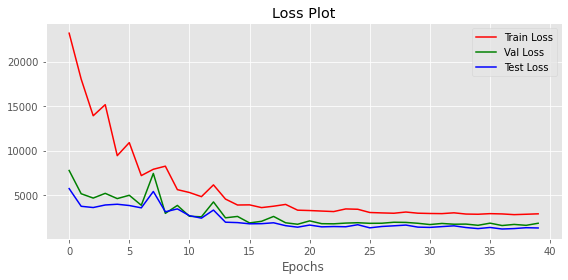

--------------------------------------------------------------------------


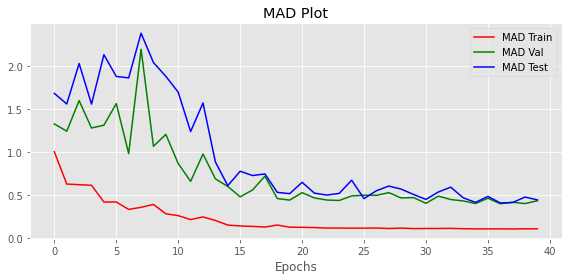

--------------------------------------------------------------------------


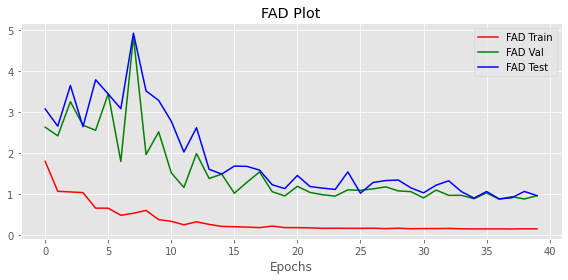

In [ ]:
# Here your code 
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## 1. Loss plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(train_loss_list, "r", label = "Train Loss")
plt.plot(val_loss_list, "g", label = "Val Loss")
plt.plot(test_loss_list, "b", label = "Test Loss")
plt.xlabel("Epochs")
plt.title("Loss Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## 2. MAD plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(mad_train_12, "r", label = "MAD Train")
plt.plot(mad_val_12, "g", label = "MAD Val")
plt.plot(mad_test_12, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## 3. FAD plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(fad_train_12, "r", label = "FAD Train")
plt.plot(fad_val_12, "g", label = "FAD Val")
plt.plot(fad_test_12, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1. Loss function: we can observe that there is the same behavior for the different three curves.
The loss decreases until 20 epochs after that converges to very low value.

2. MAD - FAD: we can see that the behavior is the same for the two metrics. For the train the curve decreases quickly and converges to 0, while for the validation and test set this does not happen and we have higher values of MAD and FAD.


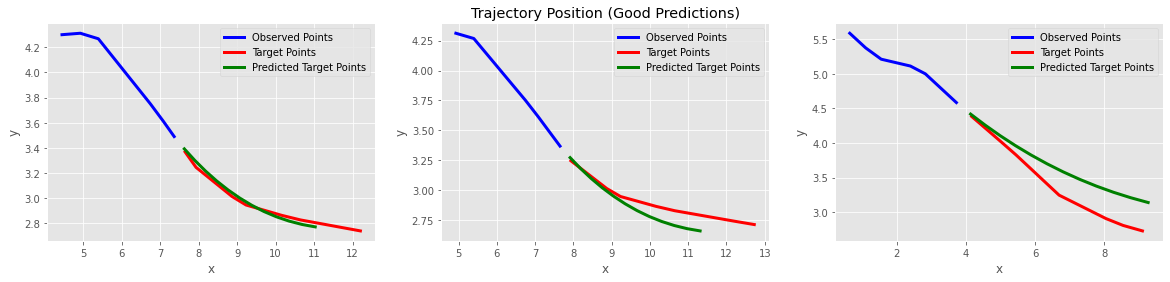

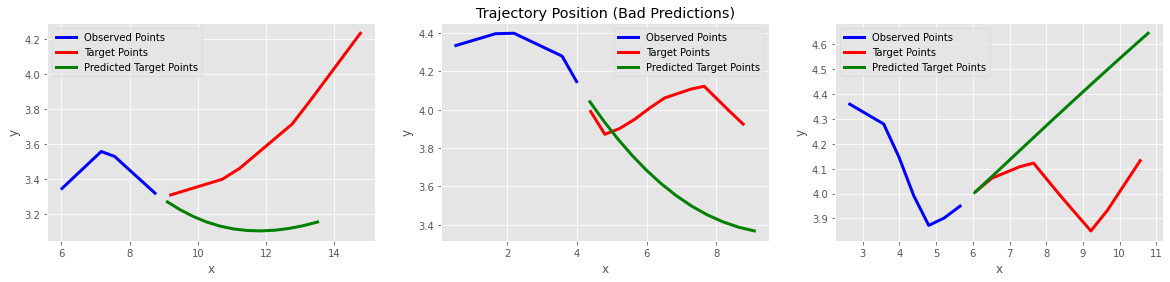

In [ ]:
## 4. Trajectory position plot

plt.rcParams["figure.figsize"] = (20,4)
## Subplot 1
plt.subplot(131)
plt.plot(obs[1360,:,0], obs[1360,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1360,:,0], gt[1360,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1360,:,0], pr[1360,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 2
plt.subplot(132)
plt.plot(obs[1361,:,0], obs[1361,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1361,:,0], gt[1361,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1361,:,0], pr[1361,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.title("Trajectory Position (Good Predictions)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 3
plt.subplot(133)
plt.plot(obs[1460,:,0], obs[1460,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1460,:,0], gt[1460,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1460,:,0], pr[1460,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

plt.rcParams["figure.figsize"] = (20,4)
## Subplot 4
plt.subplot(131)
plt.plot(obs[1500,:,0], obs[1500,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1500,:,0], gt[1500,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1500,:,0], pr[1500,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 5
plt.subplot(132)
plt.plot(obs[1501,:,0], obs[1501,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1501,:,0], gt[1501,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1501,:,0], pr[1501,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.title("Trajectory Position (Bad Predictions)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 6
plt.subplot(133)
plt.plot(obs[1505,:,0], obs[1505,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1505,:,0], gt[1505,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1505,:,0], pr[1505,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

From the trajectory position plot it's possible to see the observed points and make a comparison between the target points and the predicted target points.

As we can see, if the target points follow the same direction of the observed points, the prediction is good enough. In the other case, if we have an important change in trajectory the predictions are far away from the target points. This is what happens in the first plot of "bad predictions".
At the same time, there are poblems also when the trajectory is 'zig-zag' as is shown in the second and third plot.


## Report  (***4 POINTS***)

Here you can report comments and results for the experiments up to this point.

Perform experiments that improves the performances or that gives meaningfull insights.

I.e. what happens if we change model hyperparamenters? What if we change learning rate?

Please explain extensively the results and organize them clearly with tables, plots...

----

At this pooint, we try different combinations of factor and warmup in order to change the learning rate.

*factor* = 0.8, 1, 1.2

*warmpup* = 3, 5, 7

In [ ]:
## Function for training (input, factor, warmup)
def train_net(preds_num = 8, factor = 1, warmup = 5):

    # Arguments to setup the datasets
    dataset_name = 'zara1'
    framework = 'regr'
    obs_num = 8
    preds_num = preds_num

    # We limit the number of samples to a fixed percentage for the sake of time
    perc_data = 50

    # With predefined function we create dataset according to arguments
    train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
    val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
    test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

    # After concatenating each observed and target sequence we compute the mean and std
    mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
    std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

    batch_size = 512

    tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
    test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

    # The input for the encoder are speeds (u,v) or positions (x,y)
    enc_input_size = 2
    # The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
    # Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
    dec_input_size = 3
    # The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
    dec_output_size = 3

    emb_size = 512
    ff_size = 1024
    heads = 8
    layers = 6
    dropout = 0.1

    model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

    # optimizer
    # Argument for the optimizer 
    factor = factor
    warmup = warmup

    optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

    ## MAIN
    # compute execution time of the cell
    start_time = time.time()

    # Argument for the training 
    epoch = 0
    max_epoch = 40          # Total number of epoch
    ckp_save_step = 20      # Frequency for saving the model
    log_step = 5           # Frequency for printing the loss


    print("Start Training...\n")

    for epoch in range(max_epoch):

        if (epoch+1) % log_step == 0:
            print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

        ###### TRAIN ######
        model.train()

        train_loss=0
        gt_posit = []
        pr_posit = []
        
        for id_b, batch in enumerate(tr_dl):

            optim.optimizer.zero_grad()
            
            pred_speed = train_step(model, batch, mean, std, device)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2


            train_loss += loss.item() * batch['trg'].shape[0]

            loss.backward()
            optim.step()

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
            
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            

        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

        if (epoch+1) % log_step == 0:
            print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



        ###### VALIDATION ######
        with torch.no_grad():
            model.eval()

            val_loss = 0
            gt_posit = []
            pr_posit = []

            for id_b, batch in enumerate(val_dl):
                
                pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
                gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

                loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
                loss2 = torch.abs(pred_speed[:, :, 2]).mean()
                loss = loss1 + loss2
                val_loss += loss.item() * batch['trg'].shape[0]

                if input_type == 'speed':
                    preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
                elif input_type == 'position':
                    preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
                
                pr_posit.append(preds_tr_b)
                gt_posit.append(batch['trg'][:, :, 0:2])
                
            gt_posit = np.concatenate(gt_posit, 0)
            pr_posit = np.concatenate(pr_posit, 0)
            mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)

            if (epoch+1) % log_step == 0:
                print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



        ###### TEST ######
        # The test is same as eval 
        with torch.no_grad():
            model.eval()

            test_loss = 0
            gt = []
            obs = []
            pr = []
            
            for id_b, batch in enumerate(test_dl):

                pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
                gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

                loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
                loss2 = torch.abs(pred_speed[:, :, 2]).mean()
                loss = loss1 + loss2
                test_loss += loss.item() * batch['trg'].shape[0]


                if input_type == 'speed':
                    preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
                elif input_type == 'position':
                    preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

                pr.append(preds_tr_b)
                gt.append(batch['trg'][:, :, 0:2])
                obs.append(batch['src'][:, :, 0:2])


            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            obs = np.concatenate(obs, 0)
            mad, fad, errs = baselineUtils.distance_metrics(gt, pr)

            if (epoch+1) % log_step == 0:
                print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

        # Here we save checkpoints to avoid repeated training
        if ((epoch+1) % (ckp_save_step) == 0):
            print("Saving checkpoint... \n ")
            torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



    # print execution time
    print("Total time: %s seconds" % (time.time() - start_time))

    return {'mad':mad, 'fad':fad}

> F = 0.8 \, and \, W = [3, 5, 7]

In [ ]:
train_net_01 =  train_net(preds_num = 8, factor = 0.8, warmup = 3)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading students003_train.txt
003 / 007 - loading students001_train.txt
004 / 007 - loading biwi_eth_train.txt
005 / 007 - loading uni_examples_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_hotel_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_val.txt
002 / 007 - loading students003_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00291
Total Train Loss: 298.5165 - MAD:  0.3622 - FAD:  0.5471
Total Eval  Loss: 471.1318 - MAD:  0.7914 - FAD:  1.4144
Total Test  Loss: 481.0388 - MAD:  0.9596 - FAD:  1.4714 

---> Epoch 010/0

In [ ]:
train_net_02 = train_net(preds_num = 8, factor = 0.8, warmup = 5)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading students003_train.txt
003 / 007 - loading students001_train.txt
004 / 007 - loading biwi_eth_train.txt
005 / 007 - loading uni_examples_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_hotel_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_val.txt
002 / 007 - loading students003_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00208
Total Train Loss: 439.3659 - MAD:  0.3179 - FAD:  0.4615
Total Eval  Loss: 502.2392 - MAD:  0.5941 - FAD:  0.9747
Total Test  Loss: 533.4534 - MAD:  0.8982 - FAD:  1.3407 

---> Epoch 010/0

In [ ]:
train_net_03 = train_net(preds_num = 8, factor = 0.8, warmup = 7)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading students003_train.txt
003 / 007 - loading students001_train.txt
004 / 007 - loading biwi_eth_train.txt
005 / 007 - loading uni_examples_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_hotel_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_val.txt
002 / 007 - loading students003_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00126
Total Train Loss: 335.4356 - MAD:  0.3079 - FAD:  0.4357
Total Eval  Loss: 538.6290 - MAD:  0.7314 - FAD:  1.2668
Total Test  Loss: 544.1237 - MAD:  0.8941 - FAD:  1.3595 

---> Epoch 010/0

> F = 1 \, and \, W = [3, 5, 7]

In [ ]:
train_net_04 = train_net(preds_num = 8, factor = 1, warmup = 3)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading students003_train.txt
003 / 007 - loading students001_train.txt
004 / 007 - loading biwi_eth_train.txt
005 / 007 - loading uni_examples_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_hotel_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_val.txt
002 / 007 - loading students003_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00363
Total Train Loss: 252.5860 - MAD:  0.2474 - FAD:  0.3088
Total Eval  Loss: 454.7565 - MAD:  0.6233 - FAD:  1.0075
Total Test  Loss: 487.1930 - MAD:  0.9423 - FAD:  1.3443 

---> Epoch 010/0

In [ ]:
train_net_05 = train_net(preds_num = 8, factor = 1, warmup = 5)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading students003_train.txt
003 / 007 - loading students001_train.txt
004 / 007 - loading biwi_eth_train.txt
005 / 007 - loading uni_examples_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_hotel_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_val.txt
002 / 007 - loading students003_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00260
Total Train Loss: 396.7044 - MAD:  0.3878 - FAD:  0.6007
Total Eval  Loss: 580.4107 - MAD:  0.6739 - FAD:  1.1806
Total Test  Loss: 627.7346 - MAD:  0.9645 - FAD:  1.5420 

---> Epoch 010/0

In [ ]:
train_net_06 = train_net(preds_num = 8, factor = 1, warmup = 7)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading students003_train.txt
003 / 007 - loading students001_train.txt
004 / 007 - loading biwi_eth_train.txt
005 / 007 - loading uni_examples_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_hotel_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_val.txt
002 / 007 - loading students003_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00157
Total Train Loss: 431.8770 - MAD:  0.2936 - FAD:  0.4133
Total Eval  Loss: 674.5764 - MAD:  0.6679 - FAD:  1.1157
Total Test  Loss: 698.3827 - MAD:  0.9117 - FAD:  1.3618 

---> Epoch 010/0

> F = 1.2 \, and \, W = [3, 5, 7]

In [ ]:
train_net_07 = train_net(preds_num = 8, factor = 1.2, warmup = 3)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading students003_train.txt
003 / 007 - loading students001_train.txt
004 / 007 - loading biwi_eth_train.txt
005 / 007 - loading uni_examples_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_hotel_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_val.txt
002 / 007 - loading students003_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00436
Total Train Loss: 259.2995 - MAD:  0.2622 - FAD:  0.3421
Total Eval  Loss: 467.0615 - MAD:  0.6896 - FAD:  1.1474
Total Test  Loss: 517.4022 - MAD:  1.0465 - FAD:  1.5936 

---> Epoch 010/0

In [ ]:
train_net_08 = train_net(preds_num = 8, factor = 1.2, warmup = 5)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading students003_train.txt
003 / 007 - loading students001_train.txt
004 / 007 - loading biwi_eth_train.txt
005 / 007 - loading uni_examples_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_hotel_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_val.txt
002 / 007 - loading students003_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00312
Total Train Loss: 357.1375 - MAD:  0.4157 - FAD:  0.6535
Total Eval  Loss: 522.1697 - MAD:  0.7361 - FAD:  1.2725
Total Test  Loss: 610.5894 - MAD:  1.1640 - FAD:  1.9226 

---> Epoch 010/0

In [ ]:
train_net_09 = train_net(preds_num = 8, factor = 1.2, warmup = 7)

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading students003_train.txt
003 / 007 - loading students001_train.txt
004 / 007 - loading biwi_eth_train.txt
005 / 007 - loading uni_examples_train.txt
006 / 007 - loading crowds_zara03_train.txt
007 / 007 - loading biwi_hotel_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_val.txt
002 / 007 - loading students003_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading crowds_zara02_val.txt
007 / 007 - loading crowds_zara03_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00188
Total Train Loss: 375.8705 - MAD:  0.3000 - FAD:  0.4234
Total Eval  Loss: 511.6216 - MAD:  0.5995 - FAD:  0.9618
Total Test  Loss: 542.6053 - MAD:  0.8696 - FAD:  1.2490 

---> Epoch 010/0

In [ ]:
## Create table
data = {"MAD": [train_net_01["mad"], train_net_02["mad"], train_net_03["mad"], train_net_04["mad"],
                train_net_05["mad"], train_net_06["mad"], train_net_07["mad"], train_net_08["mad"],
                train_net_09["mad"]],
        
        "FAD": [train_net_01["fad"], train_net_02["fad"], train_net_03["fad"], train_net_04["fad"],
                train_net_05["fad"], train_net_06["fad"], train_net_07["fad"], train_net_08["fad"],
                train_net_09["fad"]]}

We can see the table below to compare the different performances

In [ ]:
import pandas as pd
df = pd.DataFrame(data, index = ["F = 0.8, W = 3", "F = 0.8, W = 5", "F = 0.8, W = 7",
                                 "F = 1, W = 3", "F = 1, W = 5", "F = 1, W = 7",
                                 "F = 1.2, W = 3", "F = 1.2, W = 5", "F = 1.2, W = 7"])
df

,MAD,FAD
"F = 0.8, W = 3",0.254052,0.534774
"F = 0.8, W = 5",0.306872,0.647253
"F = 0.8, W = 7",0.270774,0.569319
"F = 1, W = 3",0.260933,0.548304
"F = 1, W = 5",0.256583,0.533787
"F = 1, W = 7",0.258640,0.549936
"F = 1.2, W = 3",0.333429,0.711108
"F = 1.2, W = 5",0.256037,0.540661
"F = 1.2, W = 7",0.280083,0.605627


Looking the table, it's clear that with different values of *F* and *W* we obtain more or less the same performance with small variations.

## Ablation Studies

Here we ask you to change some settings in order to compare the benefit of some specific mechanism.

Please follow the instructions and create a small report for each point adding your comments supported by plots, tables with results or whatever you think is usefull.

Each extra study included to improve general performance or to draft a more complete analysis will be considered.

--------------------------------------------------------------------------

**Note**: to have a fair comparison we suggest to fix the setup (i.e. Regressive TF with speeds, obs=8, pred=12, ...) and change just the analysed module.

--------------------------------------------------------------------------

### 1. Substitute for the Prediction Framework (*6 POINTS*)
--------------------------------------------------------------------------------

The standard task is the regression of future speeds/positions.

We propose to implement to different frameworks: Gaussian and Quantized.

--------------------------------------------------------------------------------

#### a. Gaussian



Predicting normal distribution parameters mean vector $\mu = (\mu_x, \mu_y)$ and covariance matrix $\Sigma = \biggl( \begin{smallmatrix}\sigma_x^2 & \rho \sigma_x \sigma_y\\ \rho \sigma_x \sigma_y & \sigma_y^2 \end{smallmatrix}\biggr)$ of future predicition. 

Then the model output dimension is 5: 2 for mean parameters $\mu_x, \mu_y$ and 3 for the covariance parameters $\sigma_x, \sigma_y, \rho$.

---

Note: consider carefully the following code snippet. In this way we force $\sigma_x, \sigma_y$ to be positive and $\rho$ to be in $[-1, 1]$

The following lines are meant to be a hint. Integrate those into the code of the previous cells.

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'gauss'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)
if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading students001_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading uni_examples_train.txt
004 / 007 - loading crowds_zara02_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_hotel_train.txt
007 / 007 - loading students003_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading biwi_hotel_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


## Model instantiation

In [ ]:
input_type = 'speed'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

In [ ]:
batch_size = 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 6

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([ 0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device) #[512, 7, 2]

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device) #[512, 1, 7]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq


    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device) #[512, 1, 1]
        out = model(inp, dec_inp, src_att, trg_att) 
        mux = out[:, :, 0].unsqueeze(2)
        muy = out[:, :, 1].unsqueeze(2)
        sx = torch.exp(out[:, :, 2]).unsqueeze(2)
        sy = torch.exp(out[:, :, 3]).unsqueeze(2)
        corr = torch.tanh(out[:, :, 4]).unsqueeze(2)
        mask = out[:,:,5].unsqueeze(2)
        
        new_out = torch.cat((mux,muy,mask), dim = 2)
        dec_inp = torch.cat((dec_inp, new_out[:, -1:, :]), 1)
       
    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return out    

In [ ]:
# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")

## Utils for plots
train_loss_list = []
val_loss_list   = []
test_loss_list  = []

mad_train = []
mad_val   = []
mad_test  = []

fad_train = []
fad_val   = []
fad_test  = []

for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):
        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        output = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)


        mux = output[:, :, 0].unsqueeze(2)
        muy = output[:, :, 1].unsqueeze(2)
        sx = torch.exp(output[:, :, 2]).unsqueeze(2)
        sy = torch.exp(output[:, :, 3]).unsqueeze(2)
        corr = torch.tanh(output[:, :, 4]).unsqueeze(2)
        mask = output[:,:,5].unsqueeze(2)

        mean_mvnorm = torch.cat((mux, muy), dim=2).to(device)
        cov_mvnorm = torch.cat((sx**2, corr*sx*sy, corr*sx*sy, sy**2), dim=2).view((-1, sx.size(1), 2, 2)).to(device)
        
        m = MultivariateNormal(mean_mvnorm, cov_mvnorm)

        # loss
        loss1 = -m.log_prob(gt_speed).mean()
        loss2 = torch.abs(output[:, :, 5]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 10)
        optim.step()

        if input_type == 'speed':
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (output[:, :, 0:2].detach() * std.to(device) + mean.to(device)).detach().cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (output[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    train_loss_list.append(train_loss)
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
    mad_train.append(mad)
    fad_train.append(fad)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            output = eval_step(model, batch, mean, std, device, preds=preds_num)
    
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            mux = output[:, :, 0].unsqueeze(2)
            muy = output[:, :, 1].unsqueeze(2)
            sx = torch.exp(output[:, :, 2]).unsqueeze(2)
            sy = torch.exp(output[:, :, 3]).unsqueeze(2)
            corr = torch.tanh(output[:, :, 4]).unsqueeze(2)
            mask = output[:,:,5].unsqueeze(2)

            mean_mvnorm = torch.cat((mux, muy), dim=2).to(device)
            cov_mvnorm = torch.cat((sx**2, corr*sx*sy, corr*sx*sy, sy**2), dim=2).view((-1, sx.size(1), 2, 2)).to(device)
            
            m = MultivariateNormal(mean_mvnorm, cov_mvnorm)

            # loss
            loss1 = -m.log_prob(gt_speed).mean()
            loss2 = torch.abs(output[:, :, 5]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (output[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

            elif input_type == 'position':
                preds_tr_b = (output[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        val_loss_list.append(val_loss)
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        mad_val.append(mad)
        fad_val.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        obs = []
        gt  = []
        pr  = []
        
        for id_b, batch in enumerate(test_dl):
            output = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            mux = output[:, :, 0].unsqueeze(2)
            muy = output[:, :, 1].unsqueeze(2)
            sx = torch.exp(output[:, :, 2]).unsqueeze(2)
            sy = torch.exp(output[:, :, 3]).unsqueeze(2)
            corr = torch.tanh(output[:, :, 4]).unsqueeze(2)
            mask = output[:,:,5].unsqueeze(2)

            mean_mvnorm = torch.cat((mux, muy), dim=2).to(device)
            cov_mvnorm = torch.cat((sx**2, corr*sx*sy, corr*sx*sy, sy**2), dim=2).view((-1, sx.size(1), 2, 2)).to(device)
            
            m = MultivariateNormal(mean_mvnorm, cov_mvnorm)

            # loss
            loss1 = -m.log_prob(gt_speed).mean()
            loss2 = torch.abs(output[:, :, 5]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (output[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (output[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])
            obs.append(batch['src'][:, :, 0:2])

        # After concatenation we compute MAD and FAD metrics
        test_loss_list.append(test_loss) 
        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        obs = np.concatenate(obs, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)
        mad_test.append(mad)
        fad_test.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

Start Training...



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 1594.5441 - MAD:  0.9580 - FAD:  1.7028
Total Eval  Loss: 4497.5559 - MAD:  1.0505 - FAD:  1.8545
Total Test  Loss: 6696.6571 - MAD:  2.1014 - FAD:  3.5664 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 496.4257 - MAD:  0.4800 - FAD:  0.7734
Total Eval  Loss: 4603.3562 - MAD:  1.0896 - FAD:  2.0460
Total Test  Loss: 9496.0528 - MAD:  2.3976 - FAD:  4.3351 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 186.6473 - MAD:  0.3178 - FAD:  0.4363
Total Eval  Loss: 11931.3437 - MAD:  1.3446 - FAD:  2.7504
Total Test  Loss: 29029.6887 - MAD:  2.5680 - FAD:  4.8748 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: -36.4701 - MAD:  0.2728 - FAD:  0.3476
Total Eval  Loss: 14515.8232 - MAD:  1.2410 - FAD:  2.5893
Total Test  Loss: 30238.1137 - MAD:  2.4401 - FAD:  4.5536 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: -160.0152 - MAD:  0.2372 - FAD:  0.2916
Total Eval  Loss: 9878.0737 

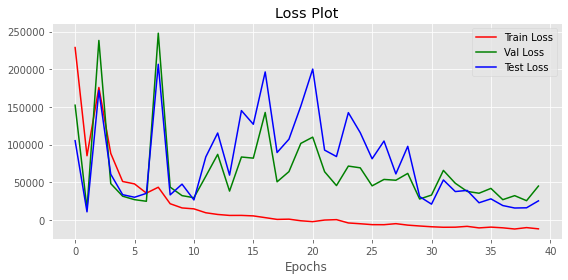

--------------------------------------------------------------------------


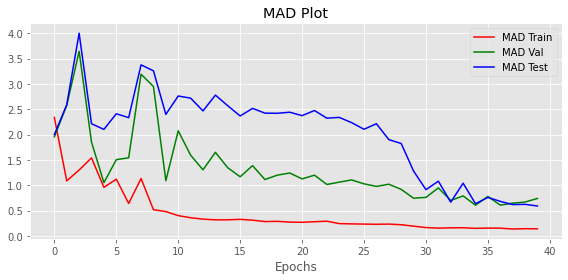

--------------------------------------------------------------------------


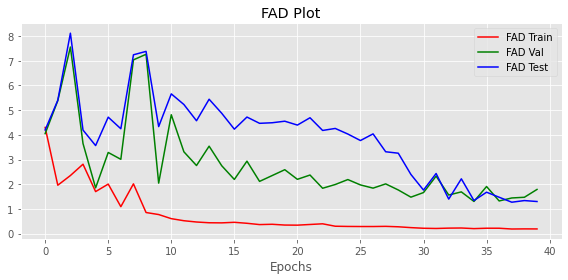

In [ ]:
## 1. Loss plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(train_loss_list, "r", label = "Train Loss")
plt.plot(val_loss_list, "g", label = "Val Loss")
plt.plot(test_loss_list, "b", label = "Test Loss")
plt.xlabel("Epochs")
plt.title("Loss Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## 2. MAD plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(mad_train, "r", label = "MAD Train")
plt.plot(mad_val, "g", label = "MAD Val")
plt.plot(mad_test, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## 3. FAD plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(fad_train, "r", label = "FAD Train")
plt.plot(fad_val, "g", label = "FAD Val")
plt.plot(fad_test, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

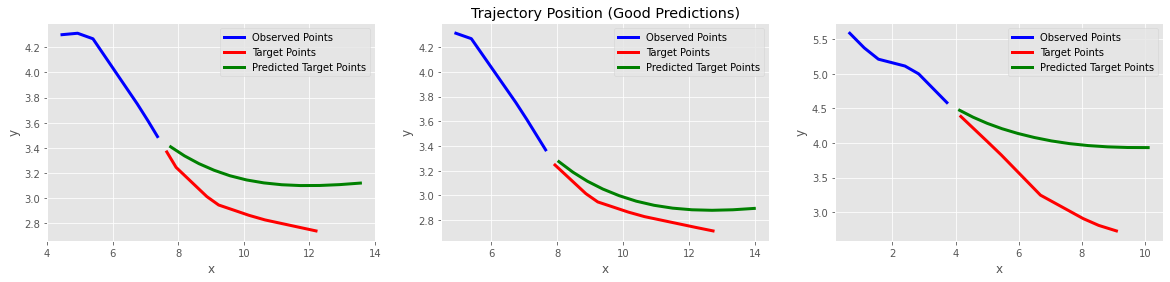

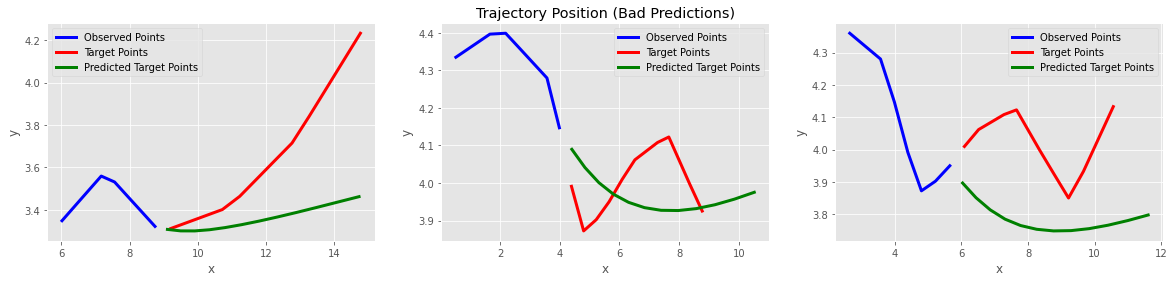

In [ ]:
## 4. Trajectory position plot

plt.rcParams["figure.figsize"] = (20,4)
## Subplot 1
plt.subplot(131)
plt.plot(obs[1360,:,0], obs[1360,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1360,:,0], gt[1360,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1360,:,0], pr[1360,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 2
plt.subplot(132)
plt.plot(obs[1361,:,0], obs[1361,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1361,:,0], gt[1361,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1361,:,0], pr[1361,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.title("Trajectory Position (Good Predictions)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 3
plt.subplot(133)
plt.plot(obs[1460,:,0], obs[1460,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1460,:,0], gt[1460,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1460,:,0], pr[1460,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

plt.rcParams["figure.figsize"] = (20,4)
## Subplot 1
plt.subplot(131)
plt.plot(obs[1500,:,0], obs[1500,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1500,:,0], gt[1500,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1500,:,0], pr[1500,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 2
plt.subplot(132)
plt.plot(obs[1501,:,0], obs[1501,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1501,:,0], gt[1501,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1501,:,0], pr[1501,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.title("Trajectory Position (Bad Predictions)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 3
plt.subplot(133)
plt.plot(obs[1505,:,0], obs[1505,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1505,:,0], gt[1505,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1505,:,0], pr[1505,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

As we can see, the performance of the gaussian framework is good in fact the MAD and FAD values are low and similar to ones obtained in the publication.

Making a comparison with the regressive framework, it's evident that the first implementation is better and we can see it looking at the metrics MAD and FAD and also at the trajectory position plot.

In fact, the predictions with this framework are away from target points with respect to the predictions obtained with the regressive framework.

### b. Quantized

Transformer was originally introduced in the NLP i.e. for next word classification task.
    
To emulate this case we change dataset (clustering all possible speed in C classes) and model to classify the most likely one (with CE loss).

Here we provide a script for the quantized dataset, so you may adapt the final part of the model to output probability score for each class (output_size=1000 + softmax) followed by CE loss.

---

Note: In the quantized framework the start of sequence token is adapted: 

The class indices spans from 0 to 999, so we add index 1000 to represent the start of sequence token

The following lines are meant to be hint, wisely integrate them with the code in the previous cells.  

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'quant'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# Load precomputed clusters to quantize the data
mat = scipy.io.loadmat(os.path.join('datasets', dataset_name, "clusters.mat"))
clusters=mat['centroids']
num_classes = clusters.shape[0]

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)
if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading biwi_eth_train.txt
002 / 007 - loading students001_train.txt
003 / 007 - loading crowds_zara03_train.txt
004 / 007 - loading biwi_hotel_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading crowds_zara02_train.txt
007 / 007 - loading uni_examples_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading students003_val.txt
002 / 007 - loading crowds_zara03_val.txt
003 / 007 - loading crowds_zara02_val.txt
004 / 007 - loading biwi_hotel_val.txt
005 / 007 - loading biwi_eth_val.txt
006 / 007 - loading uni_examples_val.txt
007 / 007 - loading students001_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'speed'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

In [ ]:
batch_size = 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = num_classes
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = num_classes+1
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = num_classes

emb_size = 512
ff_size = 2048
heads = 8
layers = 6
dropout = 0.1

In [ ]:
def train_step(model, batch, mean, std, device):

    batch_size = batch['src'].shape[0]
    
    # Associate the nearest class to each speed/position
    speeds_inp = batch['src'][:,1:,2:4] 
    inp = torch.tensor(scipy.spatial.distance.cdist(speeds_inp.reshape(-1,2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)
    inp = F.one_hot(inp, num_classes = num_classes).float()

    speeds_trg = batch['trg'][:,:,2:4]
    target = torch.tensor(scipy.spatial.distance.cdist(speeds_trg.reshape(-1, 2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)
    
    
    # We add index 1000 to represent the start of sequence token
    start_of_seq = torch.tensor([1000]).repeat(batch_size).unsqueeze(1).to(device)
    dec_inp = torch.cat((start_of_seq, target[:,:-1]), 1)
    dec_inp = F.one_hot(dec_inp).float()

    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    trg_att = subsequent_mask(target.shape[1]).repeat(batch_size, 1, 1).to(device)
    
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred

def eval_step(model, batch, mean, std, device, preds=12):

    batch_size = batch['src'].shape[0]

    # Associate the nearest class to each speed/position
    speeds_inp=batch['src'][:,1:,2:4]
    inp = torch.tensor(scipy.spatial.distance.cdist(speeds_inp.reshape(-1,2), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)
    inp = F.one_hot(inp, num_classes = num_classes).float()

    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)

    start_of_seq = torch.tensor([1000]).repeat(batch_size).unsqueeze(1).to(device)
    dec_inp = start_of_seq
    dec_inp = F.one_hot(dec_inp, num_classes = num_classes + 1).float()
    

    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)

        add_col = torch.zeros((out.shape[0], out.shape[1], 1)).to(device)
        out = torch.cat((out, add_col), dim = 2) 
        dec_inp = torch.cat((dec_inp, out[:,-1:,:]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, :-1, :-1]

In [ ]:
model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

In [ ]:
# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [ ]:
## Train the model and save utils for plots

# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")

## Utils for plots
train_loss_list = []
val_loss_list   = []
test_loss_list  = []

mad_train = []
mad_val   = []
mad_test  = []

fad_train = []
fad_val   = []
fad_test  = []

for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):
        batch_size = batch["src"].shape[0]

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        output = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2])
        target = torch.tensor(scipy.spatial.distance.cdist(gt_speed.reshape(-1, 2).cpu(), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)
       
        loss = F.cross_entropy(output.view(-1, num_classes), target.view(-1), reduction='mean')
        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]
        loss.backward()
        optim.step()

        ## Predictions
        if input_type == 'speed':
            preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(output, dim = -1).detach().cpu().numpy()].cumsum(1)

        elif input_type == 'position':
            preds_tr_b = batch['src'][:,:,0:2].cpu().numpy() + clusters[torch.argmax(output, dim = -1).detach().cpu().numpy()].cumsum(1)

        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    train_loss_list.append(train_loss)
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
    mad_train.append(mad)
    fad_train.append(fad)


    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            batch_size = batch["src"].shape[0]

            # All the gradients are resetted to zero before the training step
            optim.optimizer.zero_grad()
            
            # We predict target speeds and we save the corresponing GTs
            output = eval_step(model, batch, mean, std, device, preds=preds_num)
            # print("output shape", output.shape) ## 512, 12, 1000
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2])
            target = torch.tensor(scipy.spatial.distance.cdist(gt_speed.reshape(-1, 2).cpu(), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)
            ## print("target shape", target.shape) ## (N, d) (512, 12)

            output_permute = torch.permute(output, [0,2,1])
            ## print("output_permute", output_permute.shape) ## (N, C, d) (512, 1000, 12)
            loss = F.cross_entropy(output_permute, target, reduction='mean')
            val_loss += loss.item() * batch['trg'].shape[0]
            
            # We accumulate and visualize the loss at the end of the epoch. 
            # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.

            ## Predictions
            if input_type == 'speed':
                preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(output, dim = -1).detach().cpu().numpy()].cumsum(1)
            elif input_type == 'position':
                preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(output, dim = -1).detach().cpu().numpy()].cumsum(1)
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        val_loss_list.append(val_loss)  
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        mad_val.append(mad)
        fad_val.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        obs = []
        gt  = []
        pr  = []
        
        for id_b, batch in enumerate(test_dl):
            batch_size = batch["src"].shape[0]

            # All the gradients are resetted to zero before the training step
            optim.optimizer.zero_grad()
            
            # We predict target speeds and we save the corresponing GTs
            output = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2]).to(device)
            target = torch.tensor(scipy.spatial.distance.cdist(gt_speed.reshape(-1, 2).cpu(), clusters).argmin(axis=1).reshape(batch_size, -1)).to(device)
            
            output_permute = torch.permute(output, [0,2,1])
            loss = F.cross_entropy(output_permute, target, reduction='mean')
            # We accumulate and visualize the loss at the end of the epoch. 
            # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
            test_loss += loss.item() * batch['trg'].shape[0]
            
            ## Predictions
            if input_type == 'speed':
                preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(output, dim = -1).detach().cpu().numpy()].cumsum(1)
            elif input_type == 'position':
                preds_tr_b = batch['src'][:,-1:,0:2].cpu().numpy() + clusters[torch.argmax(output, dim = -1).detach().cpu().numpy()].cumsum(1)


            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])
            obs.append(batch['src'][:, :, 0:2])

        # After concatenation we compute MAD and FAD metrics
        test_loss_list.append(test_loss)  
        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        obs = np.concatenate(obs, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)
        mad_test.append(mad)
        fad_test.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')


# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 508.1468 - MAD:  0.1195 - FAD:  0.1602
Total Eval  Loss: 3610.1925 - MAD:  1.2085 - FAD:  2.6098
Total Test  Loss: 3544.7819 - MAD:  1.6321 - FAD:  3.6711 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 306.7422 - MAD:  0.0893 - FAD:  0.1228
Total Eval  Loss: 3978.3975 - MAD:  1.2064 - FAD:  2.5248
Total Test  Loss: 3947.9678 - MAD:  1.6577 - FAD:  3.5292 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 216.2440 - MAD:  0.0735 - FAD:  0.1020
Total Eval  Loss: 4087.3485 - MAD:  1.2505 - FAD:  2.5780
Total Test  Loss: 4022.8082 - MAD:  1.5817 - FAD:  3.3290 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 164.6802 - MAD:  0.0638 - FAD:  0.0893
Total Eval  Loss: 4070.6351 - MAD:  1.1320 - FAD:  2.2691
Total Test  Loss: 4003.2435 - MAD:  1.6775 - FAD:  3.5319 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 129.7006 - MAD:  0.0569 - FAD:  0.0812
Total Eval  Los

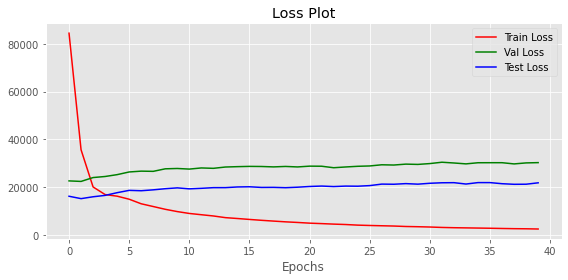

--------------------------------------------------------------------------


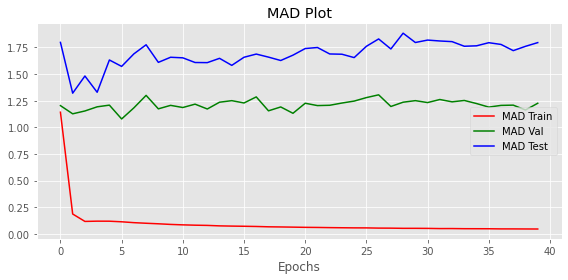

--------------------------------------------------------------------------


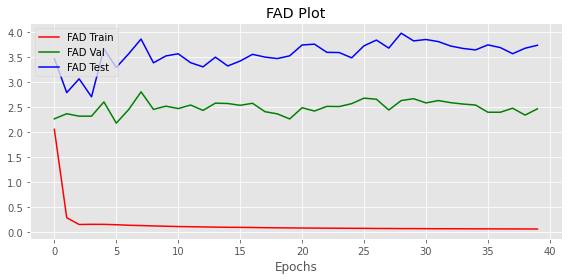

In [ ]:
## 1. Loss plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(train_loss_list, "r", label = "Train Loss")
plt.plot(val_loss_list, "g", label = "Val Loss")
plt.plot(test_loss_list, "b", label = "Test Loss")
plt.xlabel("Epochs")
plt.title("Loss Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## 2. MAD plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(mad_train, "r", label = "MAD Train")
plt.plot(mad_val, "g", label = "MAD Val")
plt.plot(mad_test, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## 3. FAD plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(fad_train, "r", label = "FAD Train")
plt.plot(fad_val, "g", label = "FAD Val")
plt.plot(fad_test, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

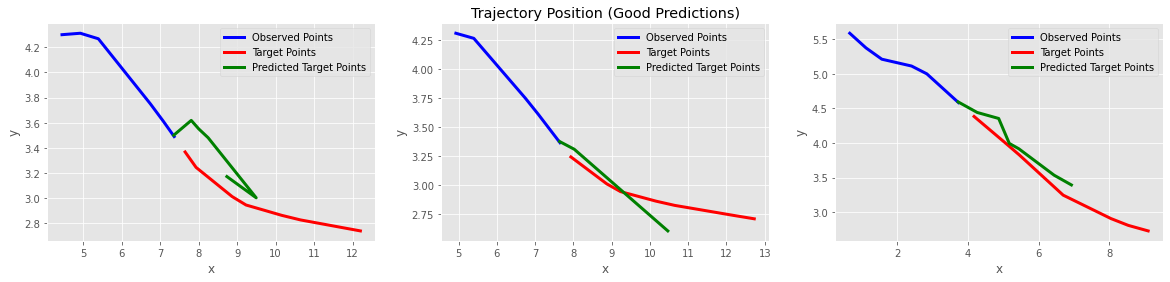

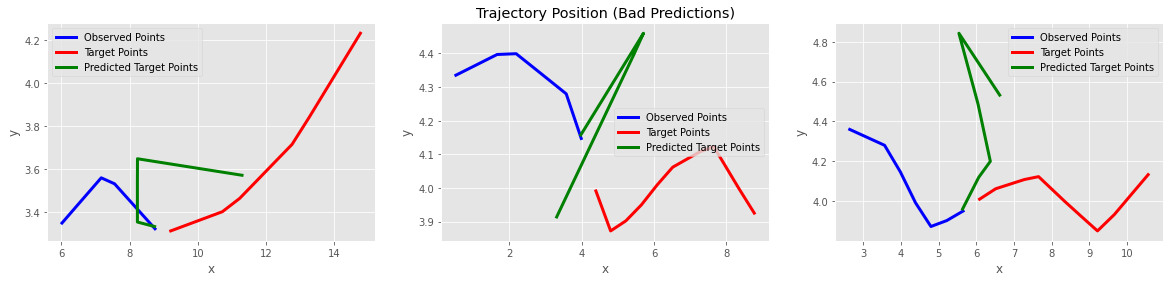

In [ ]:
## 4. Trajectory position plot

plt.rcParams["figure.figsize"] = (20,4)
## Subplot 1
plt.subplot(131)
plt.plot(obs[1360,:,0], obs[1360,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1360,:,0], gt[1360,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1360,:,0], pr[1360,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 2
plt.subplot(132)
plt.plot(obs[1361,:,0], obs[1361,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1361,:,0], gt[1361,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1361,:,0], pr[1361,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.title("Trajectory Position (Good Predictions)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 3
plt.subplot(133)
plt.plot(obs[1460,:,0], obs[1460,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1460,:,0], gt[1460,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1460,:,0], pr[1460,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

plt.rcParams["figure.figsize"] = (20,4)
## Subplot 1
plt.subplot(131)
plt.plot(obs[1500,:,0], obs[1500,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1500,:,0], gt[1500,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1500,:,0], pr[1500,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 2
plt.subplot(132)
plt.plot(obs[1501,:,0], obs[1501,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1501,:,0], gt[1501,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1501,:,0], pr[1501,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.title("Trajectory Position (Bad Predictions)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 3
plt.subplot(133)
plt.plot(obs[1505,:,0], obs[1505,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1505,:,0], gt[1505,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1505,:,0], pr[1505,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

As we can see, we obtain worst performances with respect to the previous frameworks and this is an unexpected result looking to the paper.

In fact, we see that for the training loss we have a good behavior because it decreases very quickly but it's not the same for validation and test step.

It seems that the model doesn't learn nothing.

## 2. Increase Prediction Horizon (Short- or Long-term Forecasting)  (***3 POINTS***)

---

You can easily increase/decrease the number of predictions (i.e. pred = 4, 8, 12, 20, 30, 50 ....) in the dataloader and see the effect on the MAD/FAD metric.

Report your results in a table and/or plot and comment what you see.

---

We define a function that takes in input the number of predictions and it does the computation of the model and its metrics.

In [ ]:
def train_net(preds_num, factor = 1., warmup = 5.):
    # Arguments to setup the datasets
    dataset_name = 'zara1'
    framework = 'regr'
    obs_num = 8
    preds_num = preds_num

    # We limit the number of samples to a fixed percentage for the sake of time
    perc_data = 50

    # With predefined function we create dataset according to arguments
    train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
    print("train_dataset.shape", len(train_dataset))
    val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
    test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)
    

    # After concatenating each observed and target sequence we compute the mean and std
    mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
    std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

    batch_size = 512

    tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
    test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

    enc_input_size = 2
    dec_input_size = 3
    dec_output_size = 3

    emb_size = 512
    ff_size = 1024
    heads = 8
    layers = 6
    dropout = 0.1

    model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

    # optimizer
    # Argument for the optimizer 
    factor = factor
    warmup = warmup

    optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

    ## MAIN
    # compute execution time of the cell
    start_time = time.time()

    # Argument for the training 
    epoch = 0
    max_epoch = 40          # Total number of epoch
    ckp_save_step = 20      # Frequency for saving the model
    log_step = 5           # Frequency for printing the loss


    print("Start Training...\n")

    ## Utils for plots
    train_loss_list = []
    val_loss_list   = []
    test_loss_list  = []

    mad_train = []
    mad_val   = []
    mad_test  = []

    fad_train = []
    fad_val   = []
    fad_test  = []


    for epoch in range(max_epoch):

        if (epoch+1) % log_step == 0:
            print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

        ###### TRAIN ######
        model.train()

        train_loss=0
        gt_posit = []
        pr_posit = []
        
        for id_b, batch in enumerate(tr_dl):

            # All the gradients are resetted to zero before the training step
            optim.optimizer.zero_grad()
            
            # We predict target speeds and we save the corresponing GTs
            pred_speed = train_step(model, batch, mean, std, device)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            # We compute the two losses, averaging on the batch
            loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2

            # We accumulate and visualize the loss at the end of the epoch. 
            # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
            train_loss += loss.item() * batch['trg'].shape[0]

            loss.backward()
            optim.step()

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            

        # After concatenation we compute MAD and FAD metrics
        train_loss_list.append(train_loss)
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        mad_train.append(mad)
        fad_train.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



        ###### VALIDATION ######
        # Here is all the same exept for eval_step and computation of MAD and FAD metrics
        with torch.no_grad():
            model.eval()

            val_loss = 0
            gt_posit = []
            pr_posit = []

            for id_b, batch in enumerate(val_dl):
                
                pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
                gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

                loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
                loss2 = torch.abs(pred_speed[:, :, 2]).mean()
                loss = loss1 + loss2
                val_loss += loss.item() * batch['trg'].shape[0]

                if input_type == 'speed':
                    preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
                elif input_type == 'position':
                    preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
                
                # We store both predicted and GT positions
                pr_posit.append(preds_tr_b)
                gt_posit.append(batch['trg'][:, :, 0:2])
                
            # After concatenation we compute MAD and FAD metrics
            val_loss_list.append(val_loss)
            gt_posit = np.concatenate(gt_posit, 0)
            pr_posit = np.concatenate(pr_posit, 0)
            mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
            mad_val.append(mad)
            fad_val.append(fad)

            if (epoch+1) % log_step == 0:
                print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



        ###### TEST ######
        # The test is same as eval 
        with torch.no_grad():
            model.eval()

            test_loss = 0
            gt = []
            obs = []
            pr = []
            
            for id_b, batch in enumerate(test_dl):

                pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
                gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

                loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
                loss2 = torch.abs(pred_speed[:, :, 2]).mean()
                loss = loss1 + loss2
                test_loss += loss.item() * batch['trg'].shape[0]


                if input_type == 'speed':
                    preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
                elif input_type == 'position':
                    preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

                pr.append(preds_tr_b)
                gt.append(batch['trg'][:, :, 0:2])
                obs.append(batch['src'][:, :, 0:2])


            test_loss_list.append(test_loss)
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            obs = np.concatenate(obs, 0)
            mad, fad, errs = baselineUtils.distance_metrics(gt, pr)
            mad_test.append(mad)
            fad_test.append(fad)

            if (epoch+1) % log_step == 0:
                print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # print execution time
    print("Total time: %s seconds" % (time.time() - start_time))

    return {'mad':mad, 'fad':fad,
            'mad_train': mad_train, 'mad_val':mad_val, 'mad_test':mad_test,
            'fad_train':fad_train, 'fad_val':fad_val, 'fad_test':fad_test}

We decided to increase and decrease the number of predictions. The number was set to: 4, 6, 8, 10, 14, 16. 

In [ ]:
train_net4 = train_net(4)
mad_4, fad_4, \
mad_train_4, mad_val_4, mad_test_4, \
fad_train_4, fad_val_4, fad_test_4 = [train_net4['mad'], train_net4['fad'], \
                                      train_net4['mad_train'], train_net4['mad_val'], train_net4['mad_test'], \
                                      train_net4['fad_train'], train_net4['fad_val'], train_net4['fad_test']]

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading crowds_zara03_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students001_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading uni_examples_train.txt
007 / 007 - loading biwi_eth_train.txt
train_dataset.shape 21253
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading uni_examples_val.txt
006 / 007 - loading biwi_hotel_val.txt
007 / 007 - loading biwi_eth_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00244
Total Train Loss: 336.7478 - MAD:  0.2202 - FAD:  0.3397
Total Eval  Loss: 349.3305 - MAD:  0.2085 - FAD:  0.3367
Total Test  Loss: 329.8731 - MAD:  0.1670 - FAD: 

In [ ]:
train_net6 = train_net(6)
mad_6, fad_6, \
mad_train_6, mad_val_6, mad_test_6, \
fad_train_6, fad_val_6, fad_test_6 = [train_net6['mad'], train_net6['fad'], \
                                      train_net6['mad_train'], train_net6['mad_val'], train_net6['mad_test'], \
                                      train_net6['fad_train'], train_net6['fad_val'], train_net6['fad_test']]

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading crowds_zara03_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students001_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading uni_examples_train.txt
007 / 007 - loading biwi_eth_train.txt
train_dataset.shape 19848
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading uni_examples_val.txt
006 / 007 - loading biwi_hotel_val.txt
007 / 007 - loading biwi_eth_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00253
Total Train Loss: 348.1978 - MAD:  0.3021 - FAD:  0.4679
Total Eval  Loss: 533.9723 - MAD:  0.4926 - FAD:  0.8703
Total Test  Loss: 499.2001 - MAD:  0.5260 - FAD: 

In [ ]:
train_net8 = train_net(8)
mad_8, fad_8, \
mad_train_8, mad_val_8, mad_test_8, \
fad_train_8, fad_val_8, fad_test_8 = [train_net8['mad'], train_net8['fad'], \
                                      train_net8['mad_train'], train_net8['mad_val'], train_net8['mad_test'], \
                                      train_net8['fad_train'], train_net8['fad_val'], train_net8['fad_test']]

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading crowds_zara03_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students001_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading uni_examples_train.txt
007 / 007 - loading biwi_eth_train.txt
train_dataset.shape 18544
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading uni_examples_val.txt
006 / 007 - loading biwi_hotel_val.txt
007 / 007 - loading biwi_eth_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00260
Total Train Loss: 416.0760 - MAD:  0.3872 - FAD:  0.5987
Total Eval  Loss: 648.2853 - MAD:  0.8326 - FAD:  1.5356
Total Test  Loss: 647.6674 - MAD:  0.9203 - FAD: 

In [ ]:
train_net10 = train_net(10)
mad_10, fad_10, \
mad_train_10, mad_val_10, mad_test_10, \
fad_train_10, fad_val_10, fad_test_10 = [train_net10['mad'], train_net10['fad'], \
                                      train_net10['mad_train'], train_net10['mad_val'], train_net10['mad_test'], \
                                      train_net10['fad_train'], train_net10['fad_val'], train_net10['fad_test']]

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading crowds_zara03_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students001_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading uni_examples_train.txt
007 / 007 - loading biwi_eth_train.txt
train_dataset.shape 17337
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading uni_examples_val.txt
006 / 007 - loading biwi_hotel_val.txt
007 / 007 - loading biwi_eth_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00271
Total Train Loss: 413.9335 - MAD:  0.4068 - FAD:  0.6265
Total Eval  Loss: 960.2074 - MAD:  1.2652 - FAD:  2.6073
Total Test  Loss: 959.9031 - MAD:  1.5882 - FAD: 

In [ ]:
train_net14 = train_net(14)
mad_14, fad_14, \
mad_train_14, mad_val_14, mad_test_14, \
fad_train_14, fad_val_14, fad_test_14 = [train_net14['mad'], train_net14['fad'], \
                                      train_net14['mad_train'], train_net14['mad_val'], train_net14['mad_test'], \
                                      train_net14['fad_train'], train_net14['fad_val'], train_net14['fad_test']]

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading crowds_zara03_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students001_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading uni_examples_train.txt
007 / 007 - loading biwi_eth_train.txt
train_dataset.shape 15209
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading uni_examples_val.txt
006 / 007 - loading biwi_hotel_val.txt
007 / 007 - loading biwi_eth_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00289
Total Train Loss: 387.9294 - MAD:  0.3613 - FAD:  0.5512
Total Eval  Loss: 902.9478 - MAD:  1.9476 - FAD:  4.3941
Total Test  Loss: 933.2565 - MAD:  2.3745 - FAD: 

In [ ]:
train_net16 = train_net(16)
mad_16, fad_16, \
mad_train_16, mad_val_16, mad_test_16, \
fad_train_16, fad_val_16, fad_test_16 = [train_net16['mad'], train_net16['fad'], \
                                      train_net16['mad_train'], train_net16['mad_val'], train_net16['mad_test'], \
                                      train_net16['fad_train'], train_net16['fad_val'], train_net16['fad_test']]

start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara02_train.txt
002 / 007 - loading crowds_zara03_train.txt
003 / 007 - loading biwi_hotel_train.txt
004 / 007 - loading students001_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading uni_examples_train.txt
007 / 007 - loading biwi_eth_train.txt
train_dataset.shape 14243
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading uni_examples_val.txt
006 / 007 - loading biwi_hotel_val.txt
007 / 007 - loading biwi_eth_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00299
Total Train Loss: 334.3635 - MAD:  0.3971 - FAD:  0.6335
Total Eval  Loss: 614.0626 - MAD:  1.4297 - FAD:  2.8829
Total Test  Loss: 769.1796 - MAD:  2.5543 - FAD: 

Let's plot in details MAD and FAD value during each epoch, for each model.

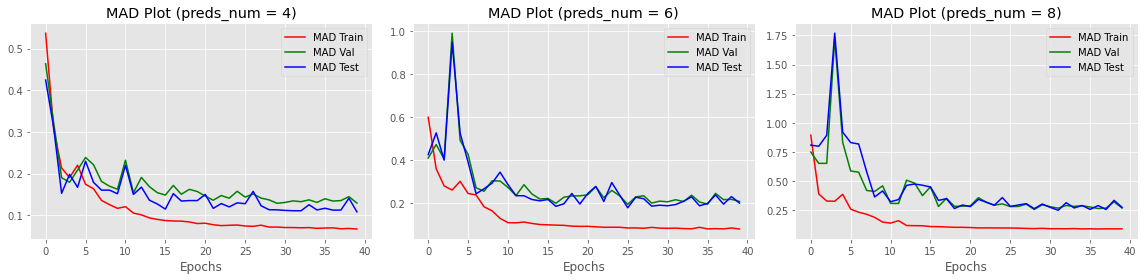

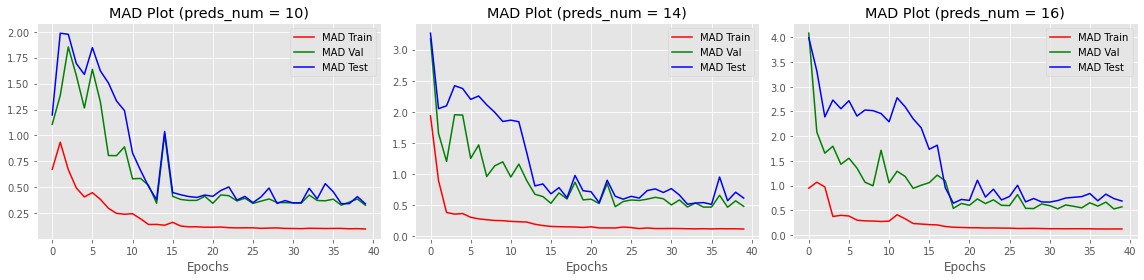

In [ ]:
plt.rcParams["figure.figsize"] = (16,4)
## Subplot 1
plt.subplot(131)
plt.plot(mad_train_4, "r", label = "MAD Train")
plt.plot(mad_val_4, "g", label = "MAD Val")
plt.plot(mad_test_4, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (preds_num = 4)")
plt.legend()
plt.grid(True)
plt.tight_layout()


## Subplot 2
plt.subplot(132)
plt.plot(mad_train_6, "r", label = "MAD Train")
plt.plot(mad_val_6, "g", label = "MAD Val")
plt.plot(mad_test_6, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (preds_num = 6)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 3
plt.subplot(133)
plt.plot(mad_train_8, "r", label = "MAD Train")
plt.plot(mad_val_8, "g", label = "MAD Val")
plt.plot(mad_test_8, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (preds_num = 8)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


plt.rcParams["figure.figsize"] = (16,4)
## Subplot 4
plt.subplot(131)
plt.plot(mad_train_10, "r", label = "MAD Train")
plt.plot(mad_val_10, "g", label = "MAD Val")
plt.plot(mad_test_10, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (preds_num = 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 5
plt.subplot(132)
plt.plot(mad_train_14, "r", label = "MAD Train")
plt.plot(mad_val_14, "g", label = "MAD Val")
plt.plot(mad_test_14, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (preds_num = 14)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 6
plt.subplot(133)
plt.plot(mad_train_16, "r", label = "MAD Train")
plt.plot(mad_val_16, "g", label = "MAD Val")
plt.plot(mad_test_16, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (preds_num = 16)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

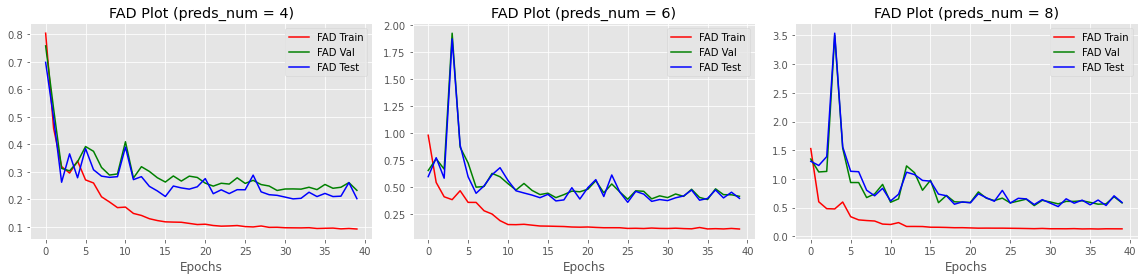

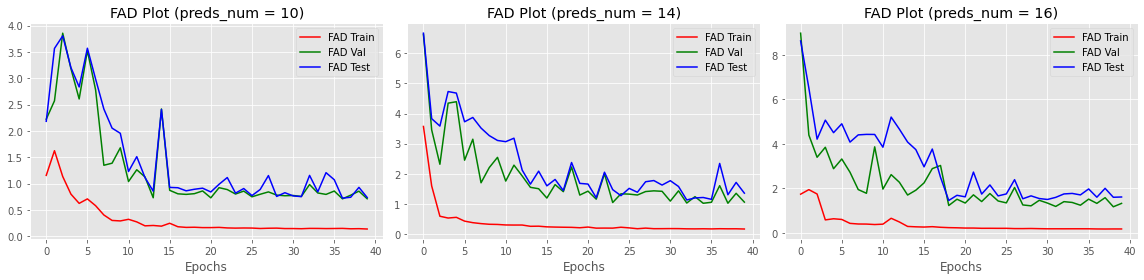

In [ ]:
plt.rcParams["figure.figsize"] = (16,4)
## Subplot 1
plt.subplot(131)
plt.plot(fad_train_4, "r", label = "FAD Train")
plt.plot(fad_val_4, "g", label = "FAD Val")
plt.plot(fad_test_4, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (preds_num = 4)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 2
plt.subplot(132)
plt.plot(fad_train_6, "r", label = "FAD Train")
plt.plot(fad_val_6, "g", label = "FAD Val")
plt.plot(fad_test_6, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (preds_num = 6)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 3
plt.subplot(133)
plt.plot(fad_train_8, "r", label = "FAD Train")
plt.plot(fad_val_8, "g", label = "FAD Val")
plt.plot(fad_test_8, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (preds_num = 8)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


plt.rcParams["figure.figsize"] = (16,4)
## Subplot 4
plt.subplot(131)
plt.plot(fad_train_10, "r", label = "FAD Train")
plt.plot(fad_val_10, "g", label = "FAD Val")
plt.plot(fad_test_10, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (preds_num = 10)")
plt.legend()
plt.grid(True)
plt.tight_layout()


## Subplot 5
plt.subplot(132)
plt.plot(fad_train_14, "r", label = "FAD Train")
plt.plot(fad_val_14, "g", label = "FAD Val")
plt.plot(fad_test_14, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (preds_num = 14)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 6
plt.subplot(133)
plt.plot(fad_train_16, "r", label = "FAD Train")
plt.plot(fad_val_16, "g", label = "FAD Val")
plt.plot(fad_test_16, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (preds_num = 16)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

Increasing the number of predictions, we can note that the MAD and the FAD values tend to zero more slowly wrt the models with a lower number of predictions.

In the following table we can see MAD and FAD metrics for the different numbers of predictions.
Note that we were able to run the model up to a number of 16 predictions; above this number we got an error due to the size of the dataset, because we use only 50% of the data.

In [ ]:
## Table with results
import pandas as pd
MADs = [mad_4, mad_6, mad_8, mad_10, mad_14, mad_16]
FADs = [fad_4, fad_6, fad_8, fad_10, fad_14, fad_16]
df = pd.DataFrame({'NumPred': [4,6,8,10,14,16], 'MAD':MADs, 'FAD':FADs}).set_index('NumPred')
df

,NumPred,MAD,FAD
0,4,0.108252,0.202806
1,6,0.200737,0.397403
2,8,0.275010,0.590658
3,10,0.340408,0.738182
4,14,0.610764,1.354481
5,16,0.685596,1.612089


It's evident that increasing the number of predictions we get a worse performance of MAD and FAD. 
Of course, having a low value of these metrics and predict a lower number of observations is not so useful, so maybe we need to find a balance between these displacements and the horizon predicted.

---

## 3. Increasing Data Number  (***3 POINTS***)

Transformers are generally very large network and need a lot of data to perform well.

Try to vary the percentage data variable (i.e. 10, 25, 50, 75, 100) and see how the performance changes.

Please report here plots and/or tables for:

1. MAD and FAD metrics 

2. Computational time

In [ ]:
def train_net_perc(perc_data = 50, preds_num = 8, factor = 1., warmup = 5.):

    # Arguments to setup the datasets
    dataset_name = 'zara1'
    framework = 'regr'
    obs_num = 8
    preds_num = preds_num

    # We limit the number of samples to a fixed percentage for the sake of time
    perc_data = perc_data

    # With predefined function we create dataset according to arguments
    train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
    print("train_dataset.shape", len(train_dataset))
    val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
    test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)
    
    mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
    std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

    batch_size = 512

    tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
    test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

    # The input for the encoder are speeds (u,v) or positions (x,y)
    enc_input_size = 2
    # The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
    # Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
    dec_input_size = 3
    # The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
    dec_output_size = 3

    emb_size = 512
    ff_size = 1024
    heads = 8
    layers = 6
    dropout = 0.1

    model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

    # optimizer
    # Argument for the optimizer 
    factor = factor
    warmup = warmup

    optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

    ## MAIN
    # compute execution time of the cell
    start_time = time.time()

    # Argument for the training 
    epoch = 0
    max_epoch = 40          # Total number of epoch
    ckp_save_step = 20      # Frequency for saving the model
    log_step = 5           # Frequency for printing the loss


    print("Start Training...\n")

    ## Utils for plots
    train_loss_list = []
    val_loss_list   = []
    test_loss_list  = []

    mad_train = []
    mad_val   = []
    mad_test  = []

    fad_train = []
    fad_val   = []
    fad_test  = []


    for epoch in range(max_epoch):

        if (epoch+1) % log_step == 0:
            print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

        ###### TRAIN ######
        model.train()

        train_loss=0
        gt_posit = []
        pr_posit = []
        
        for id_b, batch in enumerate(tr_dl):

            optim.optimizer.zero_grad()
            
            pred_speed = train_step(model, batch, mean, std, device)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2

            train_loss += loss.item() * batch['trg'].shape[0]

            loss.backward()
            optim.step()

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            

        # After concatenation we compute MAD and FAD metrics
        train_loss_list.append(train_loss)
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        mad_train.append(mad)
        fad_train.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



        ###### VALIDATION ######
        # Here is all the same exept for eval_step and computation of MAD and FAD metrics
        with torch.no_grad():
            model.eval()

            val_loss = 0
            gt_posit = []
            pr_posit = []

            for id_b, batch in enumerate(val_dl):
                
                pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
                gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

                loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
                loss2 = torch.abs(pred_speed[:, :, 2]).mean()
                loss = loss1 + loss2
                val_loss += loss.item() * batch['trg'].shape[0]

                if input_type == 'speed':
                    preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
                elif input_type == 'position':
                    preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
                
                # We store both predicted and GT positions
                pr_posit.append(preds_tr_b)
                gt_posit.append(batch['trg'][:, :, 0:2])
                
            # After concatenation we compute MAD and FAD metrics
            val_loss_list.append(val_loss)
            gt_posit = np.concatenate(gt_posit, 0)
            pr_posit = np.concatenate(pr_posit, 0)
            mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
            mad_val.append(mad)
            fad_val.append(fad)

            if (epoch+1) % log_step == 0:
                print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



        ###### TEST ######
        # The test is same as eval 
        with torch.no_grad():
            model.eval()

            test_loss = 0
            gt = []
            obs = []
            pr = []
            
            for id_b, batch in enumerate(test_dl):

                pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
                gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

                loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
                loss2 = torch.abs(pred_speed[:, :, 2]).mean()
                loss = loss1 + loss2
                test_loss += loss.item() * batch['trg'].shape[0]


                if input_type == 'speed':
                    preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
                elif input_type == 'position':
                    preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

                pr.append(preds_tr_b)
                gt.append(batch['trg'][:, :, 0:2])
                obs.append(batch['src'][:, :, 0:2])


            test_loss_list.append(test_loss)
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            obs = np.concatenate(obs, 0)
            mad, fad, errs = baselineUtils.distance_metrics(gt, pr)
            mad_test.append(mad)
            fad_test.append(fad)

            if (epoch+1) % log_step == 0:
                print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    comp_time = time.time() - start_time
    # print execution time
    print("Total time: %s seconds" % (time.time() - start_time))

    return {'mad':mad, 'fad':fad, 'comp_time':comp_time,
            'mad_train': mad_train, 'mad_val':mad_val, 'mad_test':mad_test,
            'fad_train':fad_train, 'fad_val':fad_val, 'fad_test':fad_test}

In [ ]:
## We try with different values of percentage: 25, 50, 75, 100
train_p25 = train_net_perc(perc_data = 25)
train_p50 = train_net_perc(perc_data = 50)
train_p75 = train_net_perc(perc_data = 75)
train_p100 = train_net_perc(perc_data = 100)

start loading dataset
validation set size -> 0
001 / 007 - loading biwi_hotel_train.txt
002 / 007 - loading students001_train.txt
003 / 007 - loading crowds_zara02_train.txt
004 / 007 - loading crowds_zara03_train.txt
005 / 007 - loading students003_train.txt
006 / 007 - loading uni_examples_train.txt
007 / 007 - loading biwi_eth_train.txt
train_dataset.shape 7983
start loading dataset
validation set size -> 0
001 / 007 - loading biwi_eth_val.txt
002 / 007 - loading crowds_zara03_val.txt
003 / 007 - loading crowds_zara02_val.txt
004 / 007 - loading uni_examples_val.txt
005 / 007 - loading students003_val.txt
006 / 007 - loading biwi_hotel_val.txt
007 / 007 - loading students001_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt
Start Training...

---> Epoch 005/040 <---  LR: 0.00395
Total Train Loss: 540.2630 - MAD:  0.6142 - FAD:  1.0358
Total Eval  Loss: 1203.7477 - MAD:  0.8839 - FAD:  1.5882
Total Test  Loss: 1294.2904 - MAD:  1.0630 - FAD:

In [ ]:
mad_p25, fad_p25, \
mad_train_p25, mad_val_p25, mad_test_p25, \
fad_train_p25, fad_val_p25, fad_test_p25, comp_time_p25 = [train_p25['mad'], train_p25['fad'], \
                                      train_p25['mad_train'], train_p25['mad_val'], train_p25['mad_test'], \
                                      train_p25['fad_train'], train_p25['fad_val'], train_p25['fad_test'],
                                      train_p25['comp_time']]

In [ ]:
mad_p50, fad_p50, \
mad_train_p50, mad_val_p50, mad_test_p50, \
fad_train_p50, fad_val_p50, fad_test_p50, comp_time_p50 = [train_p50['mad'], train_p50['fad'], \
                                      train_p50['mad_train'], train_p50['mad_val'], train_p50['mad_test'], \
                                      train_p50['fad_train'], train_p50['fad_val'], train_p50['fad_test'],
                                      train_p50['comp_time']]

In [ ]:
mad_p75, fad_p75, \
mad_train_p75, mad_val_p75, mad_test_p75, \
fad_train_p75, fad_val_p75, fad_test_p75, comp_time_p75 = [train_p75['mad'], train_p75['fad'], \
                                      train_p75['mad_train'], train_p75['mad_val'], train_p75['mad_test'], \
                                      train_p75['fad_train'], train_p75['fad_val'], train_p75['fad_test'],
                                      train_p75['comp_time']]

In [ ]:
mad_p100, fad_p100, \
mad_train_p100, mad_val_p100, mad_test_p100, \
fad_train_p100, fad_val_p100, fad_test_p100, comp_time_p100 = [train_p100['mad'], train_p100['fad'], \
                                      train_p100['mad_train'], train_p100['mad_val'], train_p100['mad_test'], \
                                      train_p100['fad_train'], train_p100['fad_val'], train_p100['fad_test'],
                                      train_p100['comp_time']]

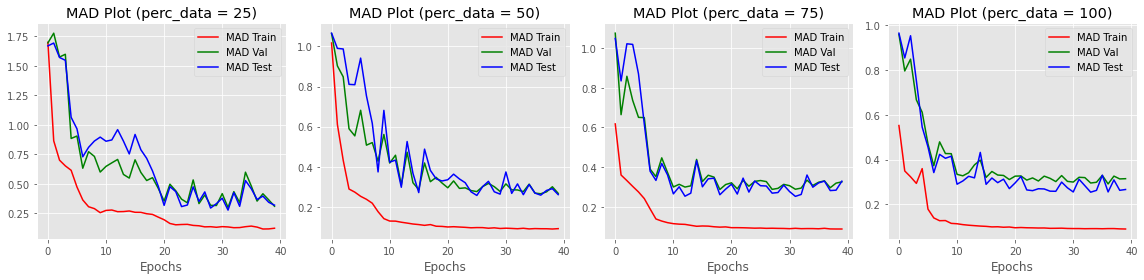

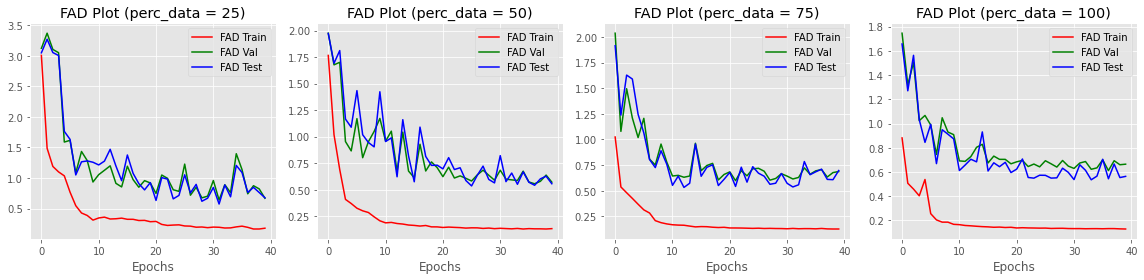

In [ ]:
plt.rcParams["figure.figsize"] = (16,4)

## Subplot 1
plt.subplot(141)
plt.plot(mad_train_p25, "r", label = "MAD Train")
plt.plot(mad_val_p25, "g", label = "MAD Val")
plt.plot(mad_test_p25, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (perc_data = 25)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 2
plt.subplot(142)
plt.plot(mad_train_p50, "r", label = "MAD Train")
plt.plot(mad_val_p50, "g", label = "MAD Val")
plt.plot(mad_test_p50, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (perc_data = 50)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 3
plt.subplot(143)
plt.plot(mad_train_p75, "r", label = "MAD Train")
plt.plot(mad_val_p75, "g", label = "MAD Val")
plt.plot(mad_test_p75, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (perc_data = 75)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 4
plt.subplot(144)
plt.plot(mad_train_p100, "r", label = "MAD Train")
plt.plot(mad_val_p100, "g", label = "MAD Val")
plt.plot(mad_test_p100, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot (perc_data = 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Subplot 5
plt.subplot(141)
plt.plot(fad_train_p25, "r", label = "FAD Train")
plt.plot(fad_val_p25, "g", label = "FAD Val")
plt.plot(fad_test_p25, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (perc_data = 25)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 6
plt.subplot(142)
plt.plot(fad_train_p50, "r", label = "FAD Train")
plt.plot(fad_val_p50, "g", label = "FAD Val")
plt.plot(fad_test_p50, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (perc_data = 50)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 7
plt.subplot(143)
plt.plot(fad_train_p75, "r", label = "FAD Train")
plt.plot(fad_val_p75, "g", label = "FAD Val")
plt.plot(fad_test_p75, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (perc_data = 75)")
plt.legend()
plt.grid(True)
plt.tight_layout()

## Subplot 8
plt.subplot(144)
plt.plot(fad_train_p100, "r", label = "FAD Train")
plt.plot(fad_val_p100, "g", label = "FAD Val")
plt.plot(fad_test_p100, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot (perc_data = 100)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
## Table with results
MADs = [mad_p25, mad_p50, mad_p75, mad_p100]
FADs = [fad_p25, fad_p50, fad_p75, fad_p100]
CTimes = [comp_time_p25, comp_time_p50, comp_time_p75, comp_time_p100]
df = pd.DataFrame({'PercData': [25, 50, 75, 100], 'MAD': MADs, 'FAD': FADs, 'CompTime': CTimes})
df

,PercData,MAD,FAD,CompTime
0,25,0.318704,0.677041,471.103797
1,50,0.261219,0.556290,889.565473
2,75,0.329024,0.696785,1258.643368
3,100,0.266299,0.563550,1433.830015


We could expect that increasing the percentage of used data we get better performances in terms of MAD and FAD, but as we can see from the previous plots and table this is not always true. In fact the best performance is obtained using the 50% of the data, while even if we increase the percentage of used data to 75% and 100% we don't observe improvements but only a worse computational time.  

## 4. Change input Type  (***2 POINTS*** - Bonus)

---

What happens if we change the input form speed type (u,v) to position one (x,y)?

Report then some quantitative results and plot trajectory predicted with both method to evaluate qualitative differences.

---

In [ ]:
# Arguments to setup the datasets
dataset_name = 'zara1'
framework = 'regr'
obs_num = 8
preds_num = 12

# We limit the number of samples to a fixed percentage for the sake of time
perc_data = 50

# With predefined function we create dataset according to arguments
train_dataset,_ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=True, perc_data=perc_data, verbose=True)
val_dataset, _  = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, perc_data=perc_data, verbose=True)
test_dataset, _ = baselineUtils.create_dataset('datasets', dataset_name, 0, obs_num, preds_num, delim='\t', train=False, eval=True, verbose=True)

# We create some folders to save model checkpoints
if not os.path.isdir("save_folder"):
    os.mkdir("save_folder")
if not os.path.isdir("save_folder/"+framework):
    os.mkdir("save_folder/"+framework)

if not os.path.isdir("save_folder/"+framework+"/"+dataset_name):
    os.mkdir("save_folder/"+framework+"/"+dataset_name)

start loading dataset
validation set size -> 0
001 / 007 - loading students001_train.txt
002 / 007 - loading biwi_eth_train.txt
003 / 007 - loading uni_examples_train.txt
004 / 007 - loading crowds_zara02_train.txt
005 / 007 - loading crowds_zara03_train.txt
006 / 007 - loading biwi_hotel_train.txt
007 / 007 - loading students003_train.txt
start loading dataset
validation set size -> 0
001 / 007 - loading crowds_zara03_val.txt
002 / 007 - loading crowds_zara02_val.txt
003 / 007 - loading students001_val.txt
004 / 007 - loading students003_val.txt
005 / 007 - loading biwi_hotel_val.txt
006 / 007 - loading biwi_eth_val.txt
007 / 007 - loading uni_examples_val.txt
start loading dataset
validation set size -> 0
001 / 001 - loading crowds_zara01.txt


In [ ]:
input_type = 'position'

if input_type == 'speed':
    input_idx_1 = 2
    input_idx_2 = 4
    first_element = 1
    
elif input_type == 'position':
    input_idx_1 = 0
    input_idx_2 = 2
    first_element = 0

We compute the mean and standard deviation of positions or speeds across the full training dataset and use those to normalize each entry in the sequence.
This normalization is beneficial prior to processing with neural networks.

In [ ]:
# After concatenating each observed and target sequence we compute the mean and std
mean = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).mean((0,1))
std  = torch.cat((train_dataset[:]['src'][:, first_element:, input_idx_1:input_idx_2], train_dataset[:]['trg'][:, :, input_idx_1:input_idx_2]), 1).std((0,1))

Following we create a torch dataloader that create the batches for each epoch.

In [ ]:
batch_size = 512

tr_dl   = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl  = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

## Model instantiation

We create an instance of our transformer with the chosen configuration. 

Then we allocate it to the GPU for forward and backward accelerated computation.

In [ ]:
# The input for the encoder are speeds (u,v) or positions (x,y)
enc_input_size = 2
# The input for the decoder are speeds (u,v) or positions (x,y) concatenated with mask array for start_of_sequence token [0, 0] 
# Corresponding to start of sequence token the mask is 1 for the other speed input the mask is 0
dec_input_size = 3
# The output of the decoder are predicted speeds and corresponding mask that should be all zero (a loss for that is dedicated)
dec_output_size = 3

emb_size = 512
ff_size = 1024
heads = 8
layers = 6
dropout = 0.1

model = individual_TF.IndividualTF(enc_input_size, dec_input_size, dec_output_size, N=layers, d_model=emb_size, d_ff=ff_size, h=heads, dropout=dropout).to(device)

## Training and Validation Step

Here we create two classes that define the single iteration function for train and validation.

In [ ]:
def train_step(model, batch, mean, std, device):

    # If input type is speed then input (or source 'src') has shape (B, N_obs-1, 2) because the first one is (0,0).
    # Otherwise, if input type is position then input  has shape (B, N_obs, 2).
    # Note that the input of the decoder are only the first  N_pred-1  GT future value then target ('trg') has shape (B, N_pred-1, 2).
    inp    = (batch['src'][:,  first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)
    target = (batch['trg'][:, :-1, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # We create a third mask channel to append to the 2 speeds. 
    # This helps the decoder differentiating between start of sequence token (with mask token 1) and target speeds (with mask token 0)
    # Summarizing: start_of_seq token is (0,0) and the mask token is 1 ---> [0, 0, 1]
    #              target inputs are (u_i, v_i) and the mask token is 0 ---> [u_i, v_i, 0]
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0], 1, 1).to(device)
    target_c = torch.zeros((target.shape[0], target.shape[1], 1)).to(device)
    target = torch.cat((target, target_c), -1)
    # Final decoder input is the concatenation of them along temporal dimension
    dec_inp = torch.cat((start_of_seq, target), 1)

    # Source attention is enabled between all the observed input (mask elements are setted to 1)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    # For the target attention we mask future elements to prevent model cheating (corresponding future mask elements are setted to False)
    # The mask is changed dinamically to use teacher forcing learning
    trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
    # Source, target and corresponding attention mask are passed to the model for the forward step
    pred = model(inp, dec_inp, src_att, trg_att)

    return pred


def eval_step(model, batch, mean, std, device, preds=12):

    # In the evaluation step we don't provide target to the decoder but we autoregressively input each prediction for the following one.
    inp = (batch['src'][:, first_element:, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

    # The decoder input is the only start of sequence token [0, 0, 1]
    # Please note that now model has to predict also the third channel mask (See loss2 in the main loop)
    src_att = torch.ones((inp.shape[0], 1, inp.shape[1])).to(device)
    start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(inp.shape[0], 1, 1).to(device)
    dec_inp = start_of_seq

    # We predict just one future speed and we append it to the decoder input for the next iteration (auto-regression)
    # At each step the target mask should be adapted
    for i in range(preds):
        trg_att = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)
        out = model(inp, dec_inp, src_att, trg_att)
        dec_inp = torch.cat((dec_inp, out[:, -1:, :]), 1)

    # Note at the each iteration of the loop we re-append the start of seq token, so after the last iteration we need to remove it
    return dec_inp[:, 1:, :]

## Optimizer

Here we select the **optimizer** proposed in the original Transformer Networks paper of Vaswani et al.

It uses some initial warmup epochs, where the learning rate is increased. Then it slowly decreases according to a number of epoch and the chosen embedding size. The resulting formula is:

LR = $\frac{F}{\sqrt{D}} min( \frac{1}{\sqrt{epoch}},\ epoch \cdot W^{-\frac{3}{2}}) $

where F is a scaling factor, D is the model embedding size, W is the number of warmup epochs.

In [ ]:
# Argument for the optimizer 
factor = 1.
warmup = 5

optim = NoamOpt(emb_size, factor, len(tr_dl)*warmup, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## Main 


Then we can train, validate and test our transformer epoch by epoch.

-------

The **losses** used are 2:

1.   $L_2$-loss distance between predicted $(\hat{\textbf{u}}, \hat{\textbf{v}})$ and GT $(\textbf{u}, \textbf{v})$ target speeds;
2.   $L_1$-loss for the target token mask. Note these should be all zero, so the loss is simply the mean.

-------

Moreover, the **metrics** used to validate the model goodness at Validation and Test time are the following:

1.   Mean Average Displacement (MAD): $L_2$-distance between *all* the $N_pred$ GT and predicted future ***positions***;
2.   Final Average Displacement (FAD): $L_2$-distance between the *last* GT and predicted future ***positions***;

-------

Note: If you restart the training for any reason, remember to instanciate again model and optimizer in order to reset them.

-------

In [ ]:
# compute execution time of the cell
start_time = time.time()

# Argument for the training 
epoch = 0
max_epoch = 40          # Total number of epoch
ckp_save_step = 20      # Frequency for saving the model
log_step = 5           # Frequency for printing the loss


print("Start Training...\n")

## Utils for plots
train_loss_list = []
val_loss_list   = []
test_loss_list  = []

mad_train_12 = []
mad_val_12   = []
mad_test_12  = []

fad_train_12 = []
fad_val_12   = []
fad_test_12  = []


for epoch in range(max_epoch):

    if (epoch+1) % log_step == 0:
        print("---> Epoch %03i/%03i <---  LR: %7.5f" % ((epoch+1), max_epoch, optim._rate))

    ###### TRAIN ######
    model.train()

    train_loss=0
    gt_posit = []
    pr_posit = []
    
    for id_b, batch in enumerate(tr_dl):

        # All the gradients are resetted to zero before the training step
        optim.optimizer.zero_grad()
        
        # We predict target speeds and we save the corresponing GTs
        pred_speed = train_step(model, batch, mean, std, device)
        gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

        # We compute the two losses, averaging on the batch
        loss1 = F.pairwise_distance(pred_speed[:, :, :2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
        loss2 = torch.abs(pred_speed[:, :, 2]).mean()
        loss = loss1 + loss2

        # We accumulate and visualize the loss at the end of the epoch. 
        # Note that here the loss is the mean on the batch but in the end we want the mean across the whole dataset.
        train_loss += loss.item() * batch['trg'].shape[0]

        loss.backward()
        optim.step()

        if input_type == 'speed':
            # If input type is speed, to compute MAD and FAD metrics we need to compute back positions from predicted speeds.
            # This is done easily adding cumulative (and denormalized) speeds to the last observed position. If last position in the input is (x_7, y_7) then:
            # (x_8, y_8)    =   (x_7, y_7) + (u_7, v_7)
            # (x_9, y_9)    =   (x_8, y_8) + (u_8, v_8)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8)
            # (x_10, y_10)  =   (x_9, y_9) + (u_9, v_9)   =   (x_7, y_7) + (u_7, v_7) + (u_8, v_8) + (u_9, v_9)
            # We have always the last observed position (x_7, y_7) and we add progressively the "cumulated" speeds
            preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)

        elif input_type == 'position':
            # If input type is position, we simply append the output
            preds_tr_b = (pred_speed[:, :, 0:2].detach() * std.to(device) + mean.to(device)).cpu().numpy()
        
        # We store both predicted and GT positions
        pr_posit.append(preds_tr_b)
        gt_posit.append(batch['trg'][:, :, 0:2])
        

    # After concatenation we compute MAD and FAD metrics
    train_loss_list.append(train_loss)
    gt_posit = np.concatenate(gt_posit, 0)
    pr_posit = np.concatenate(pr_posit, 0)
    mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
    mad_train_12.append(mad)
    fad_train_12.append(fad)

    if (epoch+1) % log_step == 0:
        print('Total Train Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (train_loss/len(tr_dl), mad, fad))



    ###### VALIDATION ######
    # Here is all the same exept for eval_step and computation of MAD and FAD metrics
    with torch.no_grad():
        model.eval()

        val_loss = 0
        gt_posit = []
        pr_posit = []

        for id_b, batch in enumerate(val_dl):
            
            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            val_loss += loss.item() * batch['trg'].shape[0]

            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()
            
            # We store both predicted and GT positions
            pr_posit.append(preds_tr_b)
            gt_posit.append(batch['trg'][:, :, 0:2])
            
        # After concatenation we compute MAD and FAD metrics
        val_loss_list.append(val_loss)
        gt_posit = np.concatenate(gt_posit, 0)
        pr_posit = np.concatenate(pr_posit, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt_posit, pr_posit)
        mad_val_12.append(mad)
        fad_val_12.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Eval  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f' % (val_loss/len(val_dl), mad, fad))



    ###### TEST ######
    # The test is same as eval 
    with torch.no_grad():
        model.eval()

        test_loss = 0
        gt = []
        obs = []
        pr = []
        
        for id_b, batch in enumerate(test_dl):

            pred_speed = eval_step(model, batch, mean, std, device, preds=preds_num)
            gt_speed = (batch['trg'][:, :, input_idx_1:input_idx_2].to(device) - mean.to(device)) / std.to(device)

            loss1 = F.pairwise_distance(pred_speed[:, :, 0:2].contiguous().view(-1, 2), gt_speed.contiguous().view(-1, 2).to(device)).mean()
            loss2 = torch.abs(pred_speed[:, :, 2]).mean()
            loss = loss1 + loss2
            test_loss += loss.item() * batch['trg'].shape[0]


            if input_type == 'speed':
                preds_tr_b = batch['src'][:, -1:, 0:2].cpu().numpy() + (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy().cumsum(1)
            elif input_type == 'position':
                preds_tr_b = (pred_speed[:, :, 0:2] * std.to(device) + mean.to(device)).cpu().numpy()

            pr.append(preds_tr_b)
            gt.append(batch['trg'][:, :, 0:2])
            obs.append(batch['src'][:, :, 0:2])


        test_loss_list.append(test_loss)
        gt = np.concatenate(gt, 0)
        pr = np.concatenate(pr, 0)
        obs = np.concatenate(obs, 0)
        mad, fad, errs = baselineUtils.distance_metrics(gt, pr)
        mad_test_12.append(mad)
        fad_test_12.append(fad)

        if (epoch+1) % log_step == 0:
            print('Total Test  Loss: %7.4f - MAD: %7.4f - FAD: %7.4f \n'% (test_loss/len(test_dl), mad, fad))

    # Here we save checkpoints to avoid repeated training
    if ((epoch+1) % (ckp_save_step) == 0):
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'save_folder/{framework}/{dataset_name}/{(epoch+1):05d}.pth')



# print execution time
print("Total time: %s seconds" % (time.time() - start_time))

Start Training...

---> Epoch 005/040 <---  LR: 0.00280
Total Train Loss: 357.1221 - MAD:  1.0305 - FAD:  0.7885
Total Eval  Loss: 816.0721 - MAD:  4.9038 - FAD:  6.8894
Total Test  Loss: 856.1670 - MAD:  5.4134 - FAD:  8.0225 

---> Epoch 010/040 <---  LR: 0.00260
Total Train Loss: 165.6574 - MAD:  0.7150 - FAD:  0.4440
Total Eval  Loss: 499.7377 - MAD:  3.2957 - FAD:  3.7145
Total Test  Loss: 423.5323 - MAD:  2.8366 - FAD:  3.6391 

---> Epoch 015/040 <---  LR: 0.00209
Total Train Loss: 70.8705 - MAD:  0.3798 - FAD:  0.3447
Total Eval  Loss: 462.0615 - MAD:  3.3486 - FAD:  6.1605
Total Test  Loss: 434.2221 - MAD:  3.2454 - FAD:  5.7771 

---> Epoch 020/040 <---  LR: 0.00179
Total Train Loss: 47.8024 - MAD:  0.2822 - FAD:  0.2758
Total Eval  Loss: 118.8388 - MAD:  0.8151 - FAD:  1.5655
Total Test  Loss: 107.1396 - MAD:  0.7631 - FAD:  1.6162 

Saving checkpoint... 
 
---> Epoch 025/040 <---  LR: 0.00159
Total Train Loss: 39.8035 - MAD:  0.2382 - FAD:  0.2315
Total Eval  Loss: 162.5493

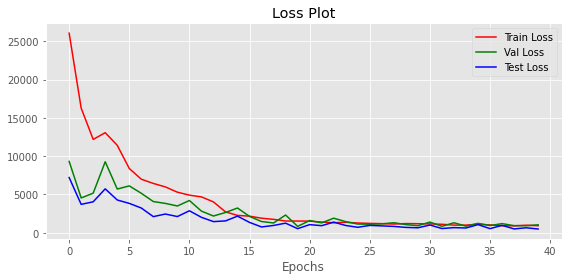

--------------------------------------------------------------------------


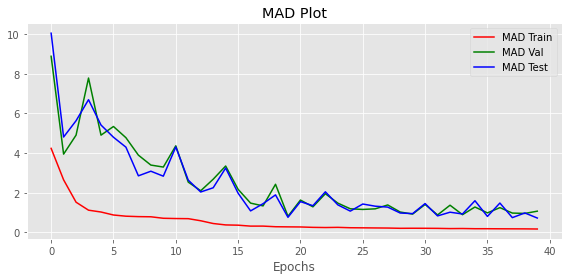

--------------------------------------------------------------------------


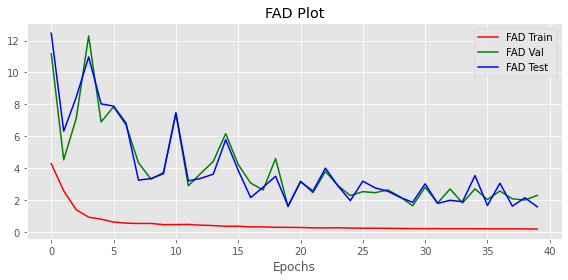

In [ ]:
## 1. Loss plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(train_loss_list, "r", label = "Train Loss")
plt.plot(val_loss_list, "g", label = "Val Loss")
plt.plot(test_loss_list, "b", label = "Test Loss")
plt.xlabel("Epochs")
plt.title("Loss Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## 2. MAD plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(mad_train_12, "r", label = "MAD Train")
plt.plot(mad_val_12, "g", label = "MAD Val")
plt.plot(mad_test_12, "b", label = "MAD Test")
plt.xlabel("Epochs")
plt.title("MAD Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("--------------------------------------------------------------------------")

## 3. FAD plot
plt.rcParams["figure.figsize"] = (8,4)
plt.plot(fad_train_12, "r", label = "FAD Train")
plt.plot(fad_val_12, "g", label = "FAD Val")
plt.plot(fad_test_12, "b", label = "FAD Test")
plt.xlabel("Epochs")
plt.title("FAD Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In this step we use the same framework of the first exercise but we use the positions as input type:

1. Loss function: we can observe that the values of the losses are smaller with respect to those computed with speed input.

2. MAD - FAD: we can see that the behavior is the same for the two metrics also using the position as input speed but the values are higher, so probably using the speed as input type is better.

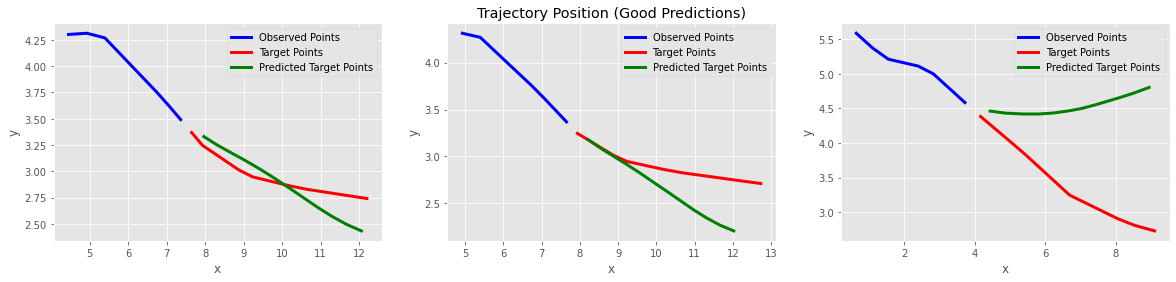

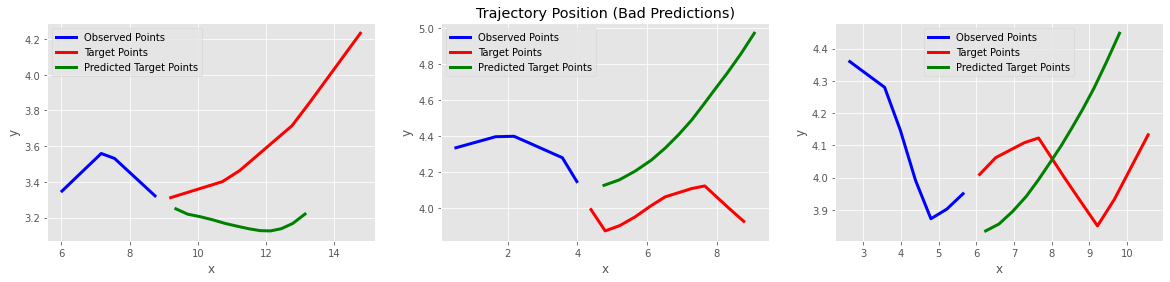

In [ ]:
## 4. Trajectory position plot

plt.rcParams["figure.figsize"] = (20,4)
## Subplot 1
plt.subplot(131)
plt.plot(obs[1360,:,0], obs[1360,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1360,:,0], gt[1360,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1360,:,0], pr[1360,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 2
plt.subplot(132)
plt.plot(obs[1361,:,0], obs[1361,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1361,:,0], gt[1361,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1361,:,0], pr[1361,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.title("Trajectory Position (Good Predictions)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 3
plt.subplot(133)
plt.plot(obs[1460,:,0], obs[1460,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1460,:,0], gt[1460,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1460,:,0], pr[1460,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

plt.rcParams["figure.figsize"] = (20,4)
## Subplot 1
plt.subplot(131)
plt.plot(obs[1500,:,0], obs[1500,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1500,:,0], gt[1500,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1500,:,0], pr[1500,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 2
plt.subplot(132)
plt.plot(obs[1501,:,0], obs[1501,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1501,:,0], gt[1501,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1501,:,0], pr[1501,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.title("Trajectory Position (Bad Predictions)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
## Subplot 3
plt.subplot(133)
plt.plot(obs[1505,:,0], obs[1505,:,1], "b", label = "Observed Points", linewidth = 3)
plt.plot(gt[1505,:,0], gt[1505,:,1], "r", label = "Target Points", linewidth = 3)
plt.plot(pr[1505,:,0], pr[1505,:,1], "g", label = "Predicted Target Points", linewidth = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

plt.show()

Also in this case we confirm that is better to use the speed as input type.

In fact using the positions and looking to the trajectory plot we worsen a performance that is already bad and also the predictions that are good using the input speed, now are not so good like the previous case.

### 5. Positional Encoding (*3 POINTS* - Bonus)


A number of positional encodings have been proposed.

Implement the plain positional encoding [0,1,2,3,4,...] and report your comments and results.

Change the commented class we prepared in the positional_encoding.py file and copy the class here.

In [ ]:
## Here yout code

Here your report

--------------------------------------------------------------------------------

This notebook was created by Luca Franco and Alessandro Flaborea.